# Introduction
https://www.kaggle.com/datasets/dilwong/flightprices

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Preprocess

Read dataset

In [1]:
import pandas as pd

df = pd.read_csv("ATL_to_LAX_nonstop_coach.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147802 entries, 0 to 147801
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              147802 non-null  object 
 1   searchDate                         147802 non-null  object 
 2   flightDate                         147802 non-null  object 
 3   startingAirport                    147802 non-null  object 
 4   destinationAirport                 147802 non-null  object 
 5   fareBasisCode                      147802 non-null  object 
 6   travelDuration                     147802 non-null  object 
 7   elapsedDays                        147802 non-null  int64  
 8   isBasicEconomy                     147802 non-null  bool   
 9   isRefundable                       147802 non-null  bool   
 10  isNonStop                          147802 non-null  bool   
 11  baseFare                           1478

Choose `totalFare`, which includes taxes and other surcharges, as the target. And drop the other price feature `baseFare`

In [12]:
df.drop(columns="baseFare", inplace=True)

Discard the features that is a conversion of the other feature
* `flightDate` << `segmentsDepartureTimeEpochSeconds`
* `segmentsDepartureTimeRaw` << `segmentsDepartureTimeEpochSeconds`
* `segmentsArrivalTimeRaw` << `segmentsArrivalTimeEpochSeconds`
* `segmentsAirlineCode` << `segmentsAirlineName`
* `segmentsDistance` << `totalTravelDistance`
* `travelDuration` << `segmentsDurationInSeconds`

In [13]:
identical_features = [
    "flightDate",
    "segmentsDepartureTimeRaw",
    "segmentsArrivalTimeRaw",
    "segmentsAirlineCode",
    "segmentsDistance",
    "travelDuration",
]
df.drop(columns=identical_features, inplace=True)

Discard the features whose values are uniform in the dataset
* `startingAirport`
* `destinationAirport`
* `isRefundable`
* `isNonStop`
* `segmentsDepartureAirportCode`
* `segmentsCabinCode`

In [14]:
def uniform_features(df: pd.DataFrame):
    res = []
    for feature in df:
        unique_values = df[feature].unique()
        if len(unique_values) == 1:
            res.append(feature)
            print(f"{feature:<30s}:\t{unique_values[0]}")
    return res

df.drop(columns=uniform_features(df), inplace=True)

startingAirport               :	ATL
destinationAirport            :	LAX
isRefundable                  :	False
isNonStop                     :	True
segmentsDepartureAirportCode  :	ATL
segmentsCabinCode             :	coach


`segmentsArrivalTimeEpochSeconds` could be calculated by adding the departure time
 `segmentsDepartureTimeEpochSeconds` to the flight duration `segmentsDurationInSeconds`.
 As a result, `segmentsArrivalTimeEpochSeconds` could be removed from the dataset."

`elapsedDays` is to indicate whether a flight crosses days. However, this information
 is already evident in `segmentsDepartureTimeEpochSeconds`, which directly provides the
 departure time of flights. Therefore, to avoid redundancy, `elapsedDays` would also be
 removed from the dataset.

Currently, only 12 columns left in `df`.

In [15]:
df.drop(
    columns=["segmentsArrivalTimeEpochSeconds", "elapsedDays"],
    inplace=True
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139763 entries, 0 to 139762
Data columns (total 12 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   legId                              139763 non-null  object        
 1   searchDate                         139763 non-null  datetime64[ns]
 2   fareBasisCode                      139763 non-null  object        
 3   isBasicEconomy                     139763 non-null  bool          
 4   totalFare                          139763 non-null  float64       
 5   seatsRemaining                     139763 non-null  int64         
 6   totalTravelDistance                128609 non-null  float32       
 7   segmentsDepartureTimeEpochSeconds  139763 non-null  datetime64[ns]
 8   segmentsArrivalAirportCode         139763 non-null  object        
 9   segmentsAirlineName                139763 non-null  object        
 10  segmentsEquipmentDes

Forecasting constants

In [16]:
LAGS = 14
N_STEPS = 7

Filter the days insufficient tickets

In [17]:
# TODO: explanation needed
import numpy as np

def convert_timestamps(df: pd.DataFrame):
    df["searchDate"] = pd.to_datetime(df["searchDate"])
    df["segmentsDepartureTimeEpochSeconds"] = pd.to_datetime(
        df["segmentsDepartureTimeEpochSeconds"],
        unit="s"
    )
    return df

df = convert_timestamps(df)

def filter_and_sort(df: pd.DataFrame):
    # Tickets with duration smaller than `LAGS + N_STEPS` were filtered
    group = df.groupby("legId")["searchDate"]
    duration = group.max() - group.min() + pd.Timedelta(days=1)
    duration = duration[duration >= pd.Timedelta(days=LAGS+N_STEPS)]
    leg_valid = duration.index
    df = df[df["legId"].isin(leg_valid)]
    # sort searchDate by their minimum date and then maximum date
    sorted_idx = np.lexsort((group.max()[leg_valid], group.min()[leg_valid]))
    sorted_legs = leg_valid[sorted_idx]

    return (
        df.set_index("legId")
        .loc[sorted_legs]
        .reset_index()
    )

df = filter_and_sort(df)

df[["segmentsEquipmentDescription", "totalTravelDistance"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139763 entries, 0 to 139762
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   segmentsEquipmentDescription  129250 non-null  object 
 1   totalTravelDistance           128609 non-null  float32
dtypes: float32(1), object(1)
memory usage: 1.6+ MB


In [18]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

# TODO: describe foward and back filling
def leg_slice_generator(df: pd.DataFrame):
    pos = 0
    for periods in df["legId"].value_counts(sort=False):
        yield slice(pos, pos+periods)
        pos += periods


def ffill_bfill(arr: np.ndarray):
    """
    Peforming foward filling and backward filling. The index of elements would be 
    created, and the indexes of nan values were set to 0.Then, doing accumulate 
    maximum to find the mamimum available indexes at current position. Finally, 
    get the filled array by the resulting indexes.
    """
    mask = np.isnan(arr)
    # return array of row indexes and the index of nan is set to 0
    idx = np.where(~mask, np.arange(arr.shape[0])[:, None], 0)
    np.maximum.accumulate(idx, axis=0, out=idx)
    # calcuating accumulate maximum in reverse order is back filling
    np.maximum.accumulate(idx[::-1], axis=0, out=idx)
    idx = idx[::-1]
    return arr[idx, np.arange(arr.shape[1])]


def impute_null_data(df: pd.DataFrame):
    arr = df[["segmentsEquipmentDescription", "totalTravelDistance"]].to_numpy()
    enc = OrdinalEncoder()
    arr = enc.fit_transform(arr)

    for slice_ in leg_slice_generator(df):
        subarr = arr[slice_]
        if np.isnan(subarr).any() and np.isnan(subarr).all() != True:
            subarr[:] = ffill_bfill(subarr)

    arr = enc.inverse_transform(arr)
    df["segmentsEquipmentDescription"] = arr[:, 0]
    df["totalTravelDistance"] = arr[:, 1].astype(np.float32)

    return df

df = impute_null_data(df)

df[["segmentsEquipmentDescription", "totalTravelDistance"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139763 entries, 0 to 139762
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   segmentsEquipmentDescription  129250 non-null  object 
 1   totalTravelDistance           128609 non-null  float32
dtypes: float32(1), object(1)
memory usage: 1.6+ MB


Null values still exists in two columns: `totalTravelDistance` and `segmentsEquipmentDescription`.

Before analyzing the dataset, separate validation set and test set from the dataset. The model should forecast 7 future timesteps, which is defined by `N_STEP`. In validtion part, backtesting will be performed instead of cross validation. `VALIDATION_FOLDS` defines how many folds were preserved to be validation set. Each fold has `N_STEP` timesteps. Thus, the last 35 days were separated into validation set.

In addition to this flight price dataset, the flight prices at May 2023 were prepared to test the performance of model. It will be covered later.

In [40]:
VALIDATION_FOLDS = 5

# declaring datatype due to pylance cannot resolve it
train: pd.DataFrame = df[
    df["searchDate"] <= df["searchDate"].max() - pd.Timedelta(days=N_STEPS * VALIDATION_FOLDS)
]

`totalTravelDistance`

The figure showed that the travel distance depends on arrival airport.
 If the arrival airport is LAX, NaN would be filled with 1943.
 For most flights arriving at ONT, the distance is 1897, so NaN would be replaced by 1897.

1897: ['ONT']	1919: ['ONT']	1943: ['LAX']	

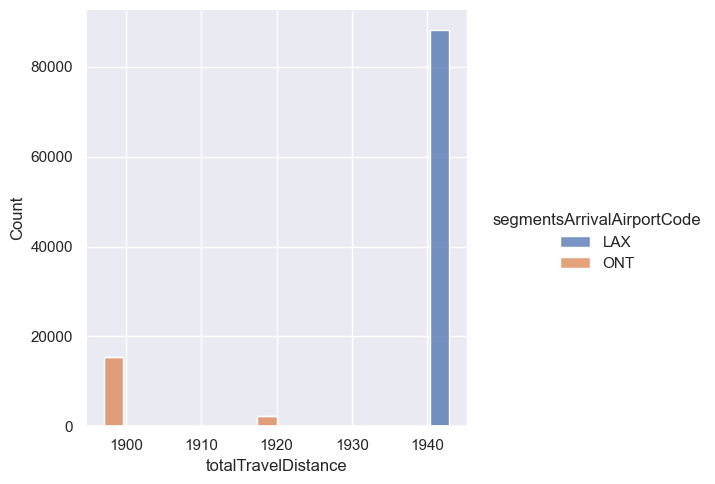

In [22]:
sns.displot(train, x="totalTravelDistance", hue="segmentsArrivalAirportCode", multiple="stack")
for distance in (1897, 1919, 1943):
    print(distance, end=": ")
    print(
        train.query("totalTravelDistance == @distance")["segmentsArrivalAirportCode"].unique(),
        end="\t"
    )

In [19]:
# TODO: need notes
def fill_distance(df: pd.DataFrame):
    distance_airport_map = {"ONT": 1897, "LAX": 1943}
    df["totalTravelDistance"].fillna(
        df["segmentsArrivalAirportCode"].map(distance_airport_map),
        inplace=True
    )
    return df

df = fill_distance(df)
df[["totalTravelDistance"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139763 entries, 0 to 139762
Data columns (total 1 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   totalTravelDistance  139763 non-null  float32
dtypes: float32(1)
memory usage: 546.1 KB


`segmentsEquipmentDescription`

Spirit Airlines and Delta are the only airlines with missing equipment information in the dataset.

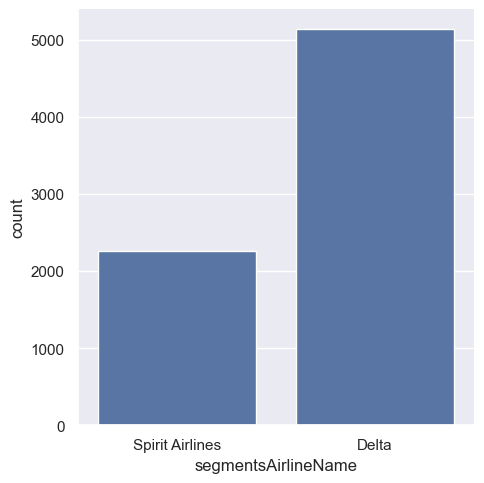

In [65]:
sns.catplot(train[train["segmentsEquipmentDescription"].isna()], x="segmentsAirlineName", kind="count")

In the figure below, flight without equipment information shares the same durations with AIRBUS INDUSTRIE A320 SHARKLETS.
 At 17040 seconds, both A320 SHARKLETS and A319 appears but A320 SHARKLETS still domain.
 Thus fill NaN with `AIRBUS INDUSTRIE A320 SHARKLETS`.

[16920 16980 17040 17100 17160 17220 17580 17640 17760 17880 17940]


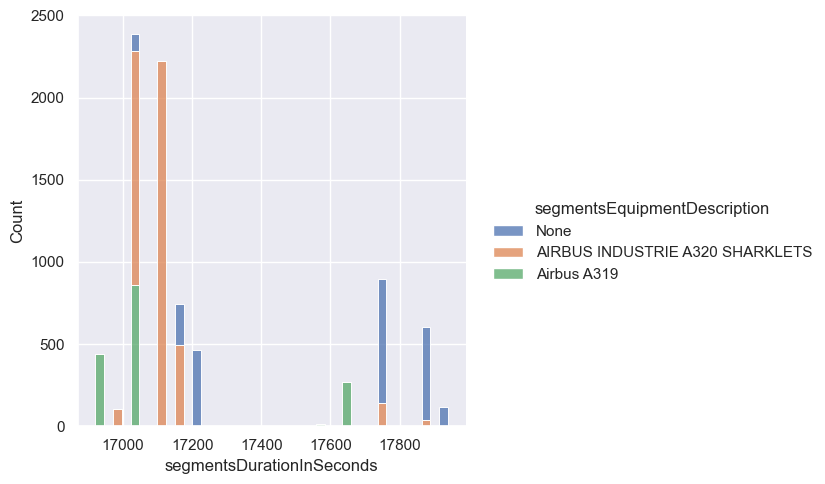

In [66]:
def plot_equipment_dist(airline_name: str, plot_args):
    airline = train.query("segmentsAirlineName == @airline_name").copy()
    null = airline["segmentsEquipmentDescription"].isna()
    airline.loc[null, "segmentsEquipmentDescription"] = "None"

    print(np.sort(airline["segmentsDurationInSeconds"].unique()))
    sns.displot(
        airline,
        x="segmentsDurationInSeconds",
        hue="segmentsEquipmentDescription",
        multiple="stack",
        **plot_args
    )

plot_equipment_dist("Spirit Airlines", {"bins": 40})

For Delta, fill `Airbus A321`

[15420 15720 15780 15840 15900 15960 16020 16140 16200 16260 16320 16380
 16440 16500 16560 16620 16680 16740 16800 16860 16920 16980 17040 17100
 17160 17220 17280 17340 17400 17460 17520 17700 17760 17820]


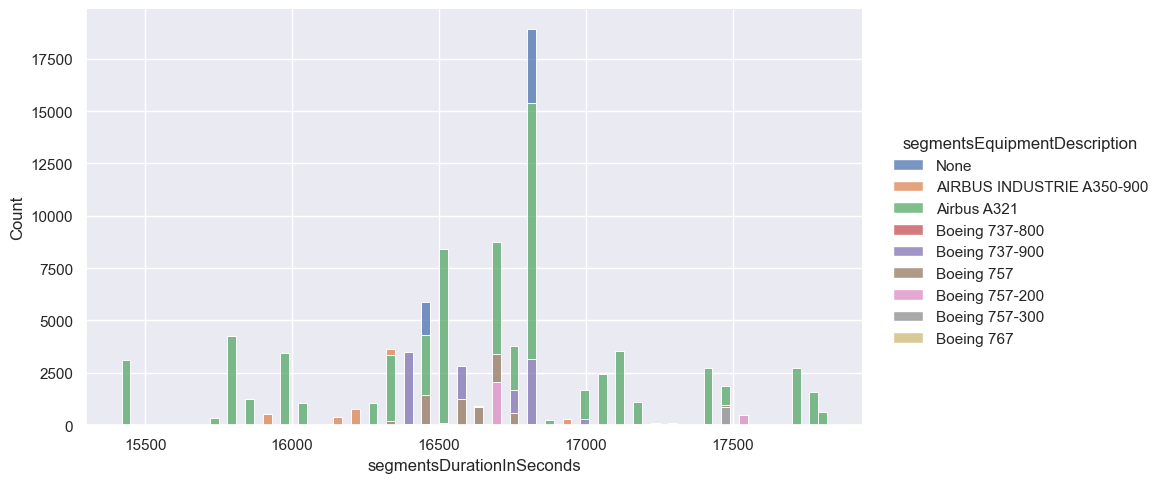

In [67]:
plot_equipment_dist(
    "Delta",
    {
        "hue_order": [
            "None",
            "AIRBUS INDUSTRIE A350-900",
            "Airbus A321",
            "Boeing 737-800",
            "Boeing 737-900",
            "Boeing 757",
            "Boeing 757-200",
            "Boeing 757-300",
            "Boeing 767"
        ],
        "bins": 80,
        "aspect": 1.8
    }
)

Fill na

In [20]:
def fill_equipment(df: pd.DataFrame):
    null = df["segmentsEquipmentDescription"].isna()
    spirit = df["segmentsAirlineName"] == "Spirit Airlines"
    delta = df["segmentsAirlineName"] == "Delta"
    df.loc[null & spirit, "segmentsEquipmentDescription"] = "AIRBUS INDUSTRIE A320 SHARKLETS"
    df.loc[null & delta, "segmentsEquipmentDescription"] = "Airbus A321"   

    return df

df = fill_equipment(df)
df[["segmentsEquipmentDescription"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139763 entries, 0 to 139762
Data columns (total 1 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   segmentsEquipmentDescription  139763 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


The `searchDate` of some flight tickets is not continuous, possibly due to data loss or not available on the website.

The dataset were imputed by forward filling. Many large arrays were declared to store imputed dataset.

The resulting arrays contain data for each day during the sales period of the flight ticket. For any missing days, the values are filled in with data from the previous available day for that specific flight ticket.

The imputation part manually manage 4 indexes of array and dataframe. Thus the imputation part is complex. Here is a simple but much slower version which gives an identical result.
<details>
<summary> Simple version </summary>

```python
pos = 0
prev_leg = None
for i in range(1, df.shape[0]):
    if df.at[i, "legId"] != prev_leg:
        date_diff = 1
        prev_leg = df.at[i, "legId"]
    else:
        date_diff = (search_date.iat[i] - search_date.iat[i-1]).days

    span = slice(pos, pos+date_diff)
    # forward filling
    str_arr[span] = str_df.iloc[i-1]
    target_arr[span] = target_df.iloc[i-1]
    num_arr[span] = num_df.iloc[i-1]
    mark_arr[pos+1:pos+date_diff] = 1
    date_arr[span, 1:] = date_df.iloc[i-1]
    # Create seachDate data for lost days
    date_arr[span, 0] = pd.date_range(search_date.iat[i-1], periods=date_diff)

    pos += date_diff

str_arr[pos] = str_df.iloc[i]
target_arr[pos] = target_df.iloc[i]
num_arr[pos] = num_df.iloc[i]
date_arr[pos, 1:] = date_df.iloc[i]
date_arr[pos, 0] = search_date.iat[i]
```

</details>

In [21]:
date_features = [
    "searchDate",
    "segmentsDepartureTimeEpochSeconds",
]
str_features = [
    "legId",
    "fareBasisCode",
    "segmentsArrivalAirportCode",
    "segmentsAirlineName",
    "segmentsEquipmentDescription",
]
target_names = [
    "totalFare",
    "seatsRemaining",
]
num_features = [
    "isBasicEconomy",
    "totalTravelDistance",
    "segmentsDurationInSeconds",
]

def impute_lost_days(df: pd.DataFrame):
    date_features = [
        "searchDate",
        "segmentsDepartureTimeEpochSeconds",
    ]
    str_features = [
        "legId",
        "fareBasisCode",
        "segmentsArrivalAirportCode",
        "segmentsAirlineName",
        "segmentsEquipmentDescription",
    ]
    num_features = [
        "totalFare",
        "seatsRemaining",
        "isBasicEconomy",
        "totalTravelDistance",
        "segmentsDurationInSeconds",
    ]
    df_arr = df.to_numpy()
    search_date_index = df.columns.get_loc("searchDate")
    search_date = df_arr[:, search_date_index].astype("datetime64[D]")

    # losing data or changing legId caused the searchDate difference not equal 1
    date_diff = np.diff(search_date) // np.timedelta64(1, "D")
    # excluding the part caused by changing legId
    leg_counts = df["legId"].value_counts(sort=False)
    leg_change_indexes = (leg_counts.to_numpy().cumsum() - 1)[:-1]
    date_diff[leg_change_indexes] = 1
    
    # calculate the corresponding indexes of existing data in the new array
    new_indexes = np.zeros(search_date.shape[0], dtype=int)
    date_diff.cumsum(out=new_indexes[1:])

    arr = np.zeros([new_indexes[-1] + 1, df.shape[1]], dtype=object)
    arr[new_indexes] = df_arr # copy the existing data to the new array

    # impute part
    mark_arr = np.zeros(arr.shape[0], dtype=np.float32)
    DAY = np.timedelta64(1, "D")
    for i in np.nonzero(date_diff != 1)[0]:
        lost_days = date_diff[i] - 1
        start =  new_indexes[i] + 1
        stop = start + lost_days
        arr[start:stop] = df_arr[i] # forward fill
        mark_arr[start:stop] = 1 # mark the imputed data
        ref_day = np.datetime64(df_arr[i, search_date_index], "D")
        arr[start:stop, search_date_index] = np.arange(
            ref_day + DAY, ref_day + DAY * date_diff[i], DAY
        )

    array_dict = {
        key: arr[:, i].astype(type_)
        for i, (key, type_) in enumerate(df.dtypes.items())
    }
    array_dict.update({"imputed": mark_arr})
    return array_dict


# def impute_lost_days(df: pd.DataFrame):
#     # Unlike DepartureTime, search_date changes everyday
#     search_date = df["searchDate"]
#     date_df = df[date_features[1:]]
#     str_df = df[str_features]
#     target_df = df[target_names]
#     num_df = df[num_features]

#     total_rows = (
#         df.groupby("legId")["searchDate"]
#         .apply(lambda x: x.max() - x.min() + pd.Timedelta(days=1))
#         .dt.days
#         .sum()
#     )
#     date_arr = np.zeros([total_rows, len(date_features)], dtype="datetime64[s]")
#     str_arr = np.zeros([total_rows, len(str_features)], dtype=object)
#     target_arr = np.zeros([total_rows, len(target_names)], dtype=np.float32)
#     num_arr = np.zeros([total_rows, len(num_features)], dtype=np.float32)
#     # extra column to mark the imputed rows
#     mark_arr = np.zeros([total_rows, 1], dtype=np.float32)

#     # imputation part
#     def _set_arrays(pos: list[int], loc: list[int], date_diff: int):
#         # Existing data were copied to array when discontinuous dates found
#         _pos = slice(*pos)
#         _loc = slice(*loc)

#         date_arr[_pos, 0] = search_date.iloc[_loc]
#         date_arr[_pos, 1:] = date_df.iloc[_loc]
#         str_arr[_pos] = str_df.iloc[_loc]
#         target_arr[_pos] = target_df.iloc[_loc]
#         num_arr[_pos] = num_df.iloc[_loc]
#         # Update slice to include lost days
#         pos[0] = pos[1]
#         loc[0] = loc[1]
#         pos[1] += date_diff
#         loc[1] += 1
#         # forward fill
#         _pos = slice(*pos)
#         _loc = loc[0]

#         date_arr[_pos, 0] = pd.date_range(
#             search_date.iat[loc[0]],
#             periods=pos[1]-pos[0],
#         )
#         date_arr[_pos, 1:] = date_df.iloc[_loc]
#         str_arr[_pos] = str_df.iloc[_loc]
#         target_arr[_pos] = target_df.iloc[_loc]
#         num_arr[_pos] = num_df.iloc[_loc]
#         mark_arr[pos[0]+1:pos[1]] = 1 # mark imputed data
#         # Update stored indexes for next round
#         pos[0] = pos[1]
#         loc[0] = loc[1]

#     pos = [0, 0]
#     loc = [0, 0]
#     prev_leg = df.at[0, "legId"]
#     prev_date = search_date.iat[0]
#     for i in range(1, df.shape[0]):
#         curr_leg = df.at[i, "legId"]
#         curr_date = search_date.iat[i]
#         date_diff = (curr_date - prev_date).days
#         # Update both for code simplicity and lower time cost compared to 2 if blocks
#         if date_diff == 1 or curr_leg != prev_leg:
#             pos[1] += 1
#             loc[1] += 1
#             prev_date = curr_date
#             prev_leg = curr_leg
#             continue

#         _set_arrays(pos, loc, date_diff)
#         prev_date = curr_date

#     _set_arrays(pos, loc, date_diff)

#     # return pd.DataFrame(
#     return (
#         {
#             **{name: date_arr[:, i] for i, name in enumerate(date_features)},
#             **{name: str_arr[:, i] for i, name in enumerate(str_features)},
#             **{name: target_arr[:, i] for i, name in enumerate(target_names)},
#             **{name: num_arr[:, i] for i, name in enumerate(num_features)},
#             "imputed": mark_arr[:, 0]
#         }
#     )

pd.DataFrame(impute_lost_days(df))

,searchDate,segmentsDepartureTimeEpochSeconds,legId,fareBasisCode,segmentsArrivalAirportCode,segmentsAirlineName,segmentsEquipmentDescription,totalFare,seatsRemaining,isBasicEconomy,totalTravelDistance,segmentsDurationInSeconds,imputed
0,2022-04-17,2022-05-08 20:02:00,0399f86eec58c6daa9589046f84696a1,MVAHZNN1,LAX,Alaska Airlines,Airbus A321,458.600006,7.0,0.0,1943.0,17820.0,0.0
1,2022-04-18,2022-05-08 20:02:00,0399f86eec58c6daa9589046f84696a1,MUAHZNN1,LAX,Alaska Airlines,Airbus A321,468.609985,7.0,0.0,1943.0,17820.0,0.0
2,2022-04-19,2022-05-08 20:02:00,0399f86eec58c6daa9589046f84696a1,LUAHZNN1,LAX,Alaska Airlines,Airbus A321,378.600006,7.0,0.0,1943.0,17820.0,0.0
3,2022-04-20,2022-05-08 20:02:00,0399f86eec58c6daa9589046f84696a1,MUAHZNN1,LAX,Alaska Airlines,Airbus A321,468.609985,7.0,0.0,1943.0,17820.0,0.0
4,2022-04-21,2022-05-08 20:02:00,0399f86eec58c6daa9589046f84696a1,MUAHZNN1,LAX,Alaska Airlines,Airbus A321,468.609985,7.0,0.0,1943.0,17820.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156692,2022-10-01,2022-11-07 17:45:00,fd89c814d3304e30c3106576d902cd51,QAUOA0MQ,LAX,Delta,Airbus A321,408.600006,9.0,0.0,1943.0,17160.0,0.0
156693,2022-10-02,2022-11-07 17:45:00,fd89c814d3304e30c3106576d902cd51,QAUOA0MQ,LAX,Delta,Airbus A321,408.600006,9.0,0.0,1943.0,17160.0,0.0
156694,2022-10-03,2022-11-07 17:45:00,fd89c814d3304e30c3106576d902cd51,QAUOA0MQ,LAX,Delta,Airbus A321,408.600006,9.0,0.0,1943.0,17160.0,0.0
156695,2022-10-04,2022-11-07 17:45:00,fd89c814d3304e30c3106576d902cd51,QAUOA0MQ,LAX,Delta,Airbus A321,408.600006,9.0,0.0,1943.0,17160.0,0.0


# Encode features

**Airline information**

The number of categories in `fareBasesCode` is quite large, and thus not suitable
 for onehot encoding. ordinal encoding and Embedding layer would be used instead.

* `fareBasisCode`

**Categorical features of low cardinality**

Perform one-hot encoding
* `segmentsAirlineName`
* `segmentsArrivalAirportCode`
* `segmentsEquipmentDescription`

**Cyclical features**
* `searchDate`
* `segmentsDepartureTimeEpochSeconds`

**Targets**
* `totalFare`
* `seatsRemaining`

**Numerical features**
* `isBasicEconomy`
* `totalTravelDistance`
* `segmentsDurationInSeconds`

**Not particapate in model training**
* `legId` # TODO
* `imputed` # TODO

CHECKPOINT

In [6]:
# df.to_feather("day_imputed_dataset.feather")
df.to_feather("processing_dataset.feather")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme()

N_STEPS = 7
LAGS = 14
VALIDATION_FOLDS = 5

df = pd.read_feather("processing_dataset.feather")
# df = pd.read_feather("day_imputed_dataset.feather")

## Encode cyclical features
The timestamps is one of the cyclical features. Sine and cosine function are the
 functions with cyclical nature. Thus the timestamps will be transformed to sine
 and cosine wave by the following equations:
$$ x_{\sin} = \sin{\frac{2 \pi x}{T}} $$
$$ x_{\cos} = \cos{\frac{2 \pi x}{T}} $$
where $x$ is the timestamps and $T$ is period which might be length of month, year, and etc. 

In [5]:
from functools import cache
from typing import Literal

import numpy as np
from numpy.typing import ArrayLike


@cache
def month_start(year, month):
    return pd.Timestamp(year=year, month=month, day=1)


def cyclic_encode(timestamps, period: Literal["day", "week", "month", "year"]):
    # """
    # Encoding features which can be converted by `pd.to_datetime`.
    # The returning features consist of sine and cosine waves with period determined
    # by the parameter `period`.

    # Parameters
    # ----------
    # timestamps : ArrayLike object of timestamps
    #     Could be converted by `pd.to_datetime`
    # period : "day", "week", "month" or "year"
    #     The period in sine and cosine wave

    # Returns
    # -------
    # tuple(x_sin, x_cos)
    # """
    if not isinstance(timestamps, pd.Series):
        timestamps = pd.Series(timestamps)

    if period == "day":
        offset = (timestamps - timestamps.dt.normalize()).dt.total_seconds()
        _period = 86400
    elif period == "week":
        # seconds of days passed this week + hour, minute and seconds
        offset = timestamps.dt.day_of_week * 86400
        offset += (timestamps - timestamps.dt.normalize()).dt.total_seconds()
        _period = 86400 * 7
    elif period == "month":
        # offset to the the beginning of the month
        offset = (
            timestamps.apply(lambda x: x - month_start(x.year, x.month))
            .dt.total_seconds()
        )
        _period = timestamps.dt.days_in_month * 86400 # 86400 seconds in a day
    elif period == "year":
        offset = timestamps.dt.day_of_year * 86400
        offset += (timestamps - timestamps.dt.normalize()).dt.total_seconds()
        _period = 86400 * 365
    else:
        raise ValueError("The parameter period only support day, week, month and year")

    basis = 2 * np.pi * offset / _period
    basis = basis.to_numpy(np.float32)
    return np.sin(basis), np.cos(basis)

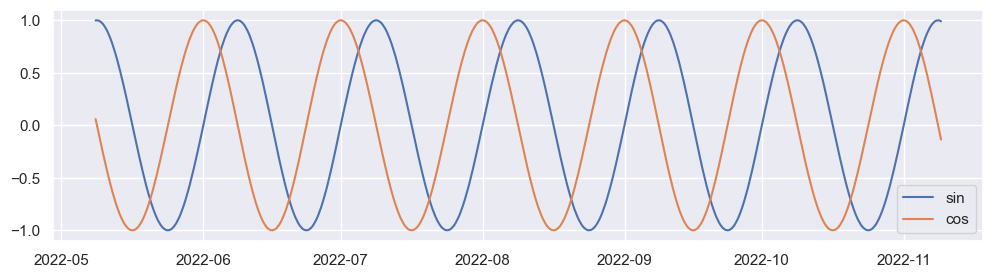

In [6]:
import matplotlib.pyplot as plt

def plot_cyclic_encoded(
    timestamps: ArrayLike,
    period: Literal["day", "week", "month", "year"],
    ax=None,
):
    sorted_idx = np.argsort(timestamps)
    sin, cos = cyclic_encode(timestamps, period=period)

    if not ax:
        _, ax = plt.subplots(figsize=(12, 3))

    ax.plot(timestamps[sorted_idx], sin[sorted_idx], label="sin")
    ax.plot(timestamps[sorted_idx], cos[sorted_idx], label="cos")
    ax.legend()


plot_cyclic_encoded(df["segmentsDepartureTimeEpochSeconds"], period="month")

# Pipeline

In [1]:
from functools import cache
from typing import Literal

import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


sns.set_theme()

LAGS = 14
N_STEPS = 7
VALIDATION_FOLDS = 5

def convert_timestamps(df: pd.DataFrame):
    df["searchDate"] = pd.to_datetime(df["searchDate"])
    df["segmentsDepartureTimeEpochSeconds"] = pd.to_datetime(
        df["segmentsDepartureTimeEpochSeconds"],
        unit="s"
    )
    return df

def filter_and_sort(df: pd.DataFrame):
    # Tickets with duration smaller than `LAGS + N_STEPS` were filtered
    group = df.groupby("legId")["searchDate"]
    duration = group.max() - group.min() + pd.Timedelta(days=1)
    duration = duration[duration >= pd.Timedelta(days=LAGS+N_STEPS)]
    leg_valid = duration.index
    df = df[df["legId"].isin(leg_valid)]
    # sort searchDate by their minimum date and then maximum date
    sorted_idx = np.lexsort((group.max()[leg_valid], group.min()[leg_valid]))
    sorted_legs = leg_valid[sorted_idx]

    return (
        df.set_index("legId")
        .loc[sorted_legs]
        .reset_index()
    )


def leg_slice_generator(df: pd.DataFrame):
    pos = 0
    for span in df["legId"].value_counts(sort=False):
        yield slice(pos, pos+span)
        pos += span


def ffill_bfill(arr: np.ndarray):
    """
    Peforming foward filling and backward filling. The index of elements would be 
    created, and the indexes of nan values were set to 0.Then, doing accumulate 
    maximum to find the mamimum available indexes at current position. Finally, 
    get the filled array by the resulting indexes.
    """
    mask = np.isnan(arr)
    # return array of row indexes and the index of nan is set to 0
    idx = np.where(~mask, np.arange(arr.shape[0])[:, None], 0)
    np.maximum.accumulate(idx, axis=0, out=idx)
    # calcuating accumulate maximum in reverse order is back filling
    np.maximum.accumulate(idx[::-1], axis=0, out=idx)
    idx = idx[::-1]
    return arr[idx, np.arange(arr.shape[1])]


def impute_null_data(df: pd.DataFrame):
    arr = df[["segmentsEquipmentDescription", "totalTravelDistance"]].to_numpy()
    enc = OrdinalEncoder()
    arr = enc.fit_transform(arr)

    for leg_slice in leg_slice_generator(df):
        subarr = arr[leg_slice]
        if np.isnan(subarr).any() and np.isnan(subarr).all() != True:
            subarr[:] = ffill_bfill(subarr)

    arr = enc.inverse_transform(arr)
    df["segmentsEquipmentDescription"] = arr[:, 0]
    df["totalTravelDistance"] = arr[:, 1].astype(np.float32)

    return df

def fill_distance(df: pd.DataFrame):
    distance_airport_map = {"ONT": 1897, "LAX": 1943}
    df["totalTravelDistance"].fillna(
        df["segmentsArrivalAirportCode"].map(distance_airport_map),
        inplace=True
    )
    return df

def fill_equipment(df: pd.DataFrame):
    null = df["segmentsEquipmentDescription"].isna()
    spirit = df["segmentsAirlineName"] == "Spirit Airlines"
    delta = df["segmentsAirlineName"] == "Delta"
    df.loc[null & spirit, "segmentsEquipmentDescription"] = "AIRBUS INDUSTRIE A320 SHARKLETS"
    df.loc[null & delta, "segmentsEquipmentDescription"] = "Airbus A321"   

    return df


date_features = [
    "searchDate",
    "segmentsDepartureTimeEpochSeconds",
]
str_features = [
    "legId",
    "fareBasisCode",
    "segmentsArrivalAirportCode",
    "segmentsAirlineName",
    "segmentsEquipmentDescription",
]
num_features = [
    "totalFare",
    "seatsRemaining",
    "isBasicEconomy",
    "totalTravelDistance",
    "segmentsDurationInSeconds",
]

def impute_lost_days(df: pd.DataFrame):
    df_arr = df.to_numpy()
    search_date_index = df.columns.get_loc("searchDate")
    search_date = df_arr[:, search_date_index].astype("datetime64[D]")

    # losing data or changing legId caused the searchDate difference not equal 1
    date_diff = np.diff(search_date) // np.timedelta64(1, "D")
    # excluding the part caused by changing legId
    leg_counts = df["legId"].value_counts(sort=False)
    leg_change_indexes = (leg_counts.to_numpy().cumsum() - 1)[:-1]
    date_diff[leg_change_indexes] = 1
    
    # calculate the corresponding indexes of existing data in the new array
    new_indexes = np.zeros(search_date.shape[0], dtype=int)
    date_diff.cumsum(out=new_indexes[1:])

    arr = np.zeros([new_indexes[-1] + 1, df.shape[1]], dtype=object)
    arr[new_indexes] = df_arr # copy the existing data to the new array

    # impute part
    mark_arr = np.zeros(arr.shape[0], dtype=np.float32)
    DAY = np.timedelta64(1, "D")
    for i in np.nonzero(date_diff != 1)[0]:
        lost_days = date_diff[i] - 1
        start =  new_indexes[i] + 1
        stop = start + lost_days
        arr[start:stop] = df_arr[i] # forward fill
        mark_arr[start:stop] = 1 # mark the imputed data
        ref_day = np.datetime64(df_arr[i, search_date_index], "D")
        arr[start:stop, search_date_index] = np.arange(
            ref_day + DAY, ref_day + DAY * date_diff[i], DAY
        )

    array_dict = {
        key: arr[:, i].astype(type_)
        for i, (key, type_) in enumerate(df.dtypes.items())
    }
    array_dict.update({"imputed": mark_arr})
    return array_dict


# def impute_lost_days_new(df: pd.DataFrame):
#     # Unlike DepartureTime, search_date changes everyday
#     search_date = df["searchDate"].to_numpy()
#     date_df = df[date_features[1:]].to_numpy()
#     str_df = df[str_features].to_numpy()
#     num_df = df[num_features].to_numpy()

#     total_rows = (
#         df.groupby("legId")["searchDate"]
#         .apply(lambda x: x.max() - x.min() + pd.Timedelta(days=1))
#         .dt.days
#         .sum()
#     )
#     date_arr = np.zeros([total_rows, len(date_features)], dtype="datetime64[s]")
#     str_arr = np.zeros([total_rows, len(str_features)], dtype=object)
#     num_arr = np.zeros([total_rows, len(num_features)], dtype=np.float32)
#     # extra column to mark the imputed rows
#     mark_arr = np.zeros(total_rows, dtype=np.float32)

#     # TODO revise the description
#     # imputation part
#     def _set_arrays(pos: list[int], loc: list[int], date_diff: int):
#         # Existing data were copied to array when discontinuous dates found
#         _pos = slice(*pos)
#         _loc = slice(*loc)

#         date_arr[_pos, 0] = search_date[_loc]
#         date_arr[_pos, 1:] = date_df[_loc]
#         str_arr[_pos] = str_df[_loc]
#         num_arr[_pos] = num_df[_loc]
#         # Update slice to include lost days
#         pos[0] = pos[1]
#         loc[0] = loc[1]
#         pos[1] += date_diff
#         loc[1] += 1
#         # forward fill
#         _pos = slice(*pos)
#         _loc = loc[0]

#         date_arr[_pos, 0] = pd.date_range(
#             search_date[_loc],
#             periods=pos[1]-pos[0],
#         )
#         date_arr[_pos, 1:] = date_df[_loc]
#         str_arr[_pos] = str_df[_loc]
#         num_arr[_pos] = num_df[_loc]
#         mark_arr[pos[0]+1:pos[1]] = 1 # mark imputed data
#         # Update stored indexes for next round
#         pos[0] = pos[1]
#         loc[0] = loc[1]


#     pos = [0, 0]
#     loc = [0, 0]
#     prev_leg = df.at[0, "legId"]
#     prev_date = search_date[0]
#     for i in range(1, df.shape[0]):
#         curr_leg = df.at[i, "legId"]
#         curr_date = search_date[i]
#         date_diff = (curr_date - prev_date) // np.timedelta64(1, "D")
#         # Update both for code simplicity and lower time cost compared to 2 if blocks
#         if date_diff == 1 or curr_leg != prev_leg:
#             pos[1] += 1
#             loc[1] += 1
#             prev_date = curr_date
#             prev_leg = curr_leg
#             continue

#         _set_arrays(pos, loc, date_diff)
#         prev_date = curr_date

#     _set_arrays(pos, loc, date_diff)

#     return {
#         **{name: date_arr[:, i] for i, name in enumerate(date_features)},
#         **{name: str_arr[:, i] for i, name in enumerate(str_features)},
#         **{name: num_arr[:, i] for i, name in enumerate(num_features)},
#         "imputed": mark_arr
#     }



# def impute_lost_days_old(df: pd.DataFrame):
#     # Unlike DepartureTime, search_date changes everyday
#     search_date = df["searchDate"]
#     date_df = df[date_features[1:]]
#     str_df = df[str_features]
#     num_df = df[num_features]

#     total_rows = (
#         df.groupby("legId")["searchDate"]
#         .apply(lambda x: x.max() - x.min() + pd.Timedelta(days=1))
#         .dt.days
#         .sum()
#     )
#     date_arr = np.zeros([total_rows, len(date_features)], dtype="datetime64[s]")
#     str_arr = np.zeros([total_rows, len(str_features)], dtype=object)
#     num_arr = np.zeros([total_rows, len(num_features)], dtype=np.float32)
#     # extra column to mark the imputed rows
#     mark_arr = np.zeros([total_rows, 1], dtype=np.float32)

#     # TODO revise the description
#     # imputation part
#     def _set_arrays(pos: list[int], loc: list[int], date_diff: int):
#         # Existing data were copied to array when discontinuous dates found
#         _pos = slice(*pos)
#         _loc = slice(*loc)

#         date_arr[_pos, 0] = search_date.iloc[_loc]
#         date_arr[_pos, 1:] = date_df.iloc[_loc]
#         str_arr[_pos] = str_df.iloc[_loc]
#         num_arr[_pos] = num_df.iloc[_loc]
#         # Update slice to include lost days
#         pos[0] = pos[1]
#         loc[0] = loc[1]
#         pos[1] += date_diff
#         loc[1] += 1
#         # forward fill
#         _pos = slice(*pos)
#         _loc = loc[0]

#         date_arr[_pos, 0] = pd.date_range(
#             search_date.iat[loc[0]],
#             periods=pos[1]-pos[0],
#         )
#         date_arr[_pos, 1:] = date_df.iloc[_loc]
#         str_arr[_pos] = str_df.iloc[_loc]
#         num_arr[_pos] = num_df.iloc[_loc]
#         mark_arr[pos[0]+1:pos[1]] = 1 # mark imputed data
#         # Update stored indexes for next round
#         pos[0] = pos[1]
#         loc[0] = loc[1]

#     pos = [0, 0]
#     loc = [0, 0]
#     prev_leg = df.at[0, "legId"]
#     prev_date = search_date.iat[0]
#     for i in range(1, df.shape[0]):
#         curr_leg = df.at[i, "legId"]
#         curr_date = search_date.iat[i]
#         date_diff = (curr_date - prev_date).days
#         # Update both for code simplicity and lower time cost compared to 2 if blocks
#         if date_diff == 1 or curr_leg != prev_leg:
#             pos[1] += 1
#             loc[1] += 1
#             prev_date = curr_date
#             prev_leg = curr_leg
#             continue

#         _set_arrays(pos, loc, date_diff)
#         prev_date = curr_date

#     _set_arrays(pos, loc, date_diff)

#     return {
#         **{name: date_arr[:, i] for i, name in enumerate(date_features)},
#         **{name: str_arr[:, i] for i, name in enumerate(str_features)},
#         **{name: num_arr[:, i] for i, name in enumerate(num_features)},
#         "imputed": mark_arr[:, 0]
#     }


@cache
def month_start(year, month):
    return pd.Timestamp(year=year, month=month, day=1)


def cyclic_encode(
    timestamps: ArrayLike, period: Literal["day", "week", "month", "year"]
):
    """
    Encoding features which can be converted by `pd.to_datetime`.
    The returning features consist of sine and cosine waves with period determined
    by the parameter `period`.

    Parameters
    ----------
    timestamps : ArrayLike object of timestamps
        Could be converted by `pd.to_datetime`
    period : "day", "week", "month" or "year"
        The period in sine and cosine wave

    Returns
    -------
    tuple(x_sin, x_cos)
    """
    if not isinstance(timestamps, pd.Series):
        timestamps = pd.Series(timestamps)

    if period == "day":
        offset = (timestamps - timestamps.dt.normalize()).dt.total_seconds()
        _period = 86400
    elif period == "week":
        # seconds of days passed this week + hour, minute and seconds
        offset = timestamps.dt.day_of_week * 86400
        offset += (timestamps - timestamps.dt.normalize()).dt.total_seconds()
        _period = 86400 * 7
    elif period == "month":
        # offset to the the beginning of the month
        offset = (
            timestamps.apply(lambda x: x - month_start(x.year, x.month))
            .dt.total_seconds()
        )
        _period = timestamps.dt.days_in_month * 86400 # 86400 seconds in a day
    elif period == "year":
        offset = timestamps.dt.day_of_year * 86400
        offset += (timestamps - timestamps.dt.normalize()).dt.total_seconds()
        _period = 86400 * 365
    else:
        raise ValueError("The parameter period only support day, week, month and year")

    basis = 2 * np.pi * offset / _period
    basis = basis.to_numpy(np.float32)
    return np.sin(basis), np.cos(basis)


In [2]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

class EncodeData:
    target_names = ("totalFare", "seatsRemaining")
    encoding_spec = {
        "Ordinal": ["fareBasisCode"],
        "OneHot": ["segmentsAirlineName", "segmentsArrivalAirportCode", "segmentsEquipmentDescription"],
    }
    encoders = {}

    def __init__(self, df: pd.DataFrame):
        if df is None:
            return
        self.data = self.clean_impute_df(df)
        self.metadata = {
            "legId": self.data.pop("legId"),
            "searchDate": self.data["searchDate"],
            "imputed" : self.data.pop("imputed"),
        }
        self.columns, self._x, self._y = self.encode()

    @classmethod
    def read_csv(cls, filepath: str, **kwargs):
        return cls(pd.read_csv(filepath, **kwargs))

    @staticmethod
    def clean_impute_df(df: pd.DataFrame) -> dict[str, np.ndarray]:
        selected_features = [
            "searchDate", "segmentsDepartureTimeEpochSeconds", "legId",
            "fareBasisCode", "segmentsArrivalAirportCode", "segmentsAirlineName",
            "segmentsEquipmentDescription", "totalFare", "seatsRemaining",
            "isBasicEconomy", "totalTravelDistance", "segmentsDurationInSeconds",
        ]
        return (
            df.loc[:, selected_features]
            .pipe(convert_timestamps)
            .pipe(filter_and_sort)
            .pipe(impute_null_data)
            .pipe(fill_distance)
            .pipe(fill_equipment)
            .pipe(impute_lost_days)
        )
    
    def fit_encoders(self):
        search_date = self.data["searchDate"]
        last_day = search_date.max() - pd.Timedelta(days=N_STEPS * VALIDATION_FOLDS)
        train_mask = search_date <= last_day

        for feature in self.encoding_spec["Ordinal"]:
            self.encoders[feature] = OrdinalEncoder(
                dtype=np.float32,
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            )
            self.encoders[feature].fit(self.data[feature][train_mask].reshape(-1, 1))
        for feature in self.encoding_spec["OneHot"]:
            self.encoders[feature] = OneHotEncoder(
                dtype=np.float32,
                handle_unknown="infrequent_if_exist",
                min_frequency=0.01,
                sparse_output=False,
                feature_name_combiner=self.feature_name_combiner(feature),
            )
            self.encoders[feature].fit(self.data[feature][train_mask].reshape(-1, 1))

    @staticmethod
    def feature_name_combiner(feature):
        def combiner(_, category):
            return f"{feature}_{category}"
        return combiner

    def encode(self):
        if not self.encoders:
            self.fit_encoders()

        # Ordinal encode
        embed_data = {}
        for feature in self.encoding_spec["Ordinal"]:
            arr = self.data.pop(feature)
            enc = self.encoders[feature]
            # +1 to make unkown value become 0. Embedding layer only accept values >= 0
            embed_data[feature] = enc.transform(arr.reshape(-1, 1)) + 1
        # One Hot encode
        for feature in self.encoding_spec["OneHot"]:
            arr = self.data.pop(feature)
            enc = self.encoders[feature]
            arr = enc.transform(arr.reshape(-1, 1))
            self.data.update(
                {name: arr[:, i] for i, name in enumerate(enc.get_feature_names_out())}
            )
        # Cyclic encode
        period_args = {
            "searchDate": ["week", "month", "year"],
            "segmentsDepartureTimeEpochSeconds": ["day", "week", "month", "year"],
        }
        for feature, period_list in period_args.items():
            arr = self.data.pop(feature)
            for period in period_list:
                waves = cyclic_encode(arr, period=period)
                descr = f"{feature}_{period}"
                self.data.update({f"{descr}_sin": waves[0], f"{descr}_cos": waves[1]})

        # return (columns, x, y)
        return (
            tuple(tuple(data.keys()) for data in (self.data, embed_data)),
            tuple(
                np.column_stack(tuple(data.values())).astype(np.float32)
                for data in (self.data, embed_data)
            ),
            np.column_stack(tuple(self.data[name] for name in self.target_names)),
        )

In [3]:
from dataclasses import field, dataclass

@dataclass
class WindowData:
    x: tuple[list | np.ndarray] = field(default_factory=list)
    y: list | np.ndarray = field(default_factory=list)
    imputed_x: list | np.ndarray = field(default_factory=list)
    imputed_y: list | np.ndarray = field(default_factory=list)
    date: list | np.ndarray = field(default_factory=list)

    @classmethod
    def sliding_window(cls, encoded: EncodeData):
        window = cls(x=tuple([] for _ in encoded._x))
        causal = cls()

        search_date = encoded.metadata["searchDate"].reshape(-1, 1)
        imputed = encoded.metadata["imputed"].reshape(-1, 1)
        for leg_slice in window._leg_slice_generator(encoded.metadata["legId"]):
            # append windowed samples
            for frag_list, arr in zip(window.x, encoded._x):
                frag_list.append(cls._window_x(arr[leg_slice]))
            window.y.append(cls._window_y(encoded._y[leg_slice]))
            window.imputed_x.append(cls._window_x(imputed[leg_slice]))
            window.imputed_y.append(cls._window_y(imputed[leg_slice]))
            window.date.append(cls._window_y(search_date[leg_slice]))
            # dataset for causal model only changes those related to output (y)
            causal.y.append(cls._window_y(encoded._y[leg_slice], causal=True))
            causal.imputed_y.append(cls._window_y(imputed[leg_slice], causal=True))

        window._vstack_samples()
        causal._vstack_samples()
        # convert imputed counts to imputed rate (percentage)
        window.imputed_x = cls._compute_imputed_rate(window.imputed_x)
        window.imputed_y = cls._compute_imputed_rate(window.imputed_y)
        causal.imputed_y = cls._compute_imputed_rate(causal.imputed_y)
        # use last date of samples to split train, validation and test set
        window.date = window.date[:, -1].flatten()
        ind = np.argsort(window.date)
        window.apply_index(ind)
        causal.apply_index(ind)
        # reference the attributes from `window` because they are all the same
        causal.x = window.x
        causal.imputed_x = window.imputed_x
        causal.date = window.date

        return window, causal
    
    def _vstack_samples(self):
        for field_name in self.__dataclass_fields__:
            attr = getattr(self, field_name)
            if isinstance(attr, list) and attr:
                attr = np.vstack(attr)
            elif isinstance(attr, tuple):
                attr = tuple(np.vstack(arr) for arr in attr)
            else:
                continue
            setattr(self, field_name, attr)

    @staticmethod
    def _leg_slice_generator(leg_id_array: np.ndarray):
        leg_counts = pd.Series(leg_id_array).value_counts(sort=False)
        pos = 0
        for span in leg_counts:
            yield slice(pos, pos+span)
            pos += span

    @staticmethod
    def _window_x(array: np.ndarray):
        return np.lib.stride_tricks.sliding_window_view(
            array[:-N_STEPS], window_shape=LAGS, axis=0
        ).swapaxes(1, 2)

    @staticmethod
    def _window_y(array: np.ndarray, causal: bool = False):
        if causal:
            return np.lib.stride_tricks.sliding_window_view(
                array[1:], window_shape=(N_STEPS, LAGS), axis=(0, 0)
            ).swapaxes(1, 3)
        else:
            return np.lib.stride_tricks.sliding_window_view(
                array[LAGS:], window_shape=N_STEPS, axis=0
            ).swapaxes(1, 2)

    @staticmethod
    def _compute_imputed_rate(imputed: np.ndarray):
        axis_to_sum = tuple(range(1, imputed.ndim))
        return imputed.sum(axis=axis_to_sum) / np.prod(imputed.shape[1:])
    
    def apply_index(self, ind: np.ndarray):
        for field_name in self.__dataclass_fields__:
            attr = getattr(self, field_name)
            if isinstance(attr, np.ndarray):
                attr = attr[ind]
            elif isinstance(attr, tuple):
                attr = tuple(arr[ind] for arr in attr)
            else:
                continue
            setattr(self, field_name, attr)

In [4]:
# encoded = EncodeData.read_csv("ATL_to_LAX_nonstop_coach.csv")
# print(encoded.columns)
# window, causal = WindowData.sliding_window(encoded)

(('totalFare', 'seatsRemaining', 'isBasicEconomy', 'totalTravelDistance', 'segmentsDurationInSeconds', 'segmentsAirlineName_Alaska Airlines', 'segmentsAirlineName_American Airlines', 'segmentsAirlineName_Delta', 'segmentsAirlineName_Spirit Airlines', 'segmentsArrivalAirportCode_LAX', 'segmentsArrivalAirportCode_ONT', 'segmentsEquipmentDescription_AIRBUS INDUSTRIE A320 SHARKLETS', 'segmentsEquipmentDescription_AIRBUS INDUSTRIE A350-900', 'segmentsEquipmentDescription_Airbus A319', 'segmentsEquipmentDescription_Airbus A320', 'segmentsEquipmentDescription_Airbus A321', 'segmentsEquipmentDescription_Boeing 737-900', 'segmentsEquipmentDescription_Boeing 757', 'segmentsEquipmentDescription_Boeing 757-200', 'segmentsEquipmentDescription_infrequent_sklearn', 'searchDate_week_sin', 'searchDate_week_cos', 'searchDate_month_sin', 'searchDate_month_cos', 'searchDate_year_sin', 'searchDate_year_cos', 'segmentsDepartureTimeEpochSeconds_day_sin', 'segmentsDepartureTimeEpochSeconds_day_cos', 'segments

In [5]:
# import joblib

# joblib.dump(encoded, "EncodeData_encoded.gz")
# joblib.dump(window, "WindowData_window.gz")
# joblib.dump(causal, "WindowData_causal.gz")

['WindowData_causal.gz']

In [4]:
import joblib

window = joblib.load("WindowData_window.gz")
# causal = joblib.load("WindowData_causal.gz")

In [7]:
class SplitData:
    def __init__(self, window: WindowData) -> None:
        self.window = window
        self._normalization_params = []

    @property
    def sample_weight(self):
        return (1 - self.window.imputed_x) * (1 - self.window.imputed_y)

    def train_valid_split(self, n_folds: int = VALIDATION_FOLDS):
        self._normalization_params.clear()
        x, y = self.window.x, self.window.y
        train_boundary = self.window.date.max() - np.timedelta64(N_STEPS * n_folds, "D")
        for _ in range(n_folds):
            valid_boundary = train_boundary + np.timedelta64(N_STEPS, "D")
            train_mask = self.window.date <= train_boundary
            valid_mask = (self.window.date <= valid_boundary) ^ train_mask
            kwargs = {
                "x": [arr[train_mask] for arr in x],
                "y": [arr[train_mask] for arr in np.rollaxis(y, axis=-1)],
                "validation_data": (
                    [arr[valid_mask] for arr in x],
                    [arr[valid_mask] for arr in np.rollaxis(y, axis=-1)],
                ),
                "sample_weight": self.sample_weight[train_mask],
            }
            yield self._normalize_split(kwargs)
            # yield kwargs
            train_boundary = valid_boundary

    # def _normalize_split(self, split_dict):
    #     params = {}
    #     for i, key in enumerate(("x", "y")):
    #         dest = []
    #         for j, arr in enumerate(split_dict[key]):
    #             norm_train, norm_valid, mean, std = self.normalize(
    #                 arr, split_dict["validation_data"][i][j]
    #             )
    #             split_dict[key][j] = norm_train
    #             split_dict["validation_data"][i][j] = norm_valid
    #             dest.append((mean, std))
    #         params[key] = tuple(dest)
    #     self._normalization_params.append(params)
    #     return split_dict

    def _normalize_split(self, split_dict):
        params = {} # parameters are mean and std
        # features to embed do not need normalization
        x_train, x_valid = split_dict["x"], split_dict["validation_data"][0]
        norm_train, norm_valid, mean, std = self.normalize(x_train[0], x_valid[0])
        x_train[0], x_valid[0] = norm_train, norm_valid
        params["x"] = (mean, std)

        # only normalize the regression target: totalFare
        y_train, y_valid = split_dict["y"], split_dict["validation_data"][1]
        norm_train, norm_valid, mean, std = self.normalize(y_train[0], y_valid[0])
        y_train[0], y_valid[0] = norm_train, norm_valid
        params["y"] = (mean, std)
        self._normalization_params.append(params) # save params in object
        return split_dict

    # def _normalize_split(self, split_dict):
    #     params = {} # parameters are mean and std
    #     dest = []
    #     x_train, x_valid = split_dict["x"], split_dict["validation_data"][0]
    #     for i, arr in enumerate(x_train):
    #         norm_train, norm_valid, mean, std = self.normalize(arr, x_valid[i])
    #         x_train[i], x_valid[i] = norm_train, norm_valid
    #         dest.append((mean ,std))
    #     params["x"] = tuple(dest)
    #     # only normalize the regression target: totalFare
    #     y_train, y_valid = split_dict["y"], split_dict["validation_data"][1]
    #     norm_train, norm_valid, mean, std = self.normalize(y_train[0], y_valid[0])
    #     y_train[0], y_valid[0] = norm_train, norm_valid
    #     params["y"] = (mean, std)
    #     self._normalization_params.append(params) # save params in object
    #     return split_dict

    @staticmethod
    def normalize(train: np.ndarray, valid: np.ndarray):
        # if the array only contains 1 feature, the shape would be (samples, timesteps)
        ndim = max(train.ndim, 3) # ensure calling mean/std like 3d array
        axes = tuple(range(ndim - 1))
        mean = train.mean(axis=axes)
        std = train.std(axis=axes)
        return (train - mean) / std, (valid - mean) / std, mean, std

    def denormalize_fare(self, array: np.ndarray, nth_fold: int = -1):
        mean, std = self._normalization_params[nth_fold]["y"]
        return array * std + mean

Save a denormalized y_true to make evaluation easier

In [167]:
def save_window_y_true(window: WindowData):
    splits = SplitData(window)
    fare_list = []
    seat_list = []
    for i, kwargs in enumerate(splits.train_valid_split()):
        y_valid = kwargs["validation_data"][1]
        fare_list.append(splits.denormalize_fare(y_valid[0], i))
        seat_list.append(y_valid[1])
    np.savez_compressed(
        f"models/y_true.npz", fare=np.vstack(fare_list), seat=np.vstack(seat_list)
    )

save_window_y_true(window)

In [34]:
from sklearn.base import clone
from tqdm import tqdm

def collapse_2d(x: np.ndarray):
    last_x = x[:, -1]
    # [0, 1] are indexes of totalFare and seatsRemaining
    targets_x = x[:, :-1, [0, 1]].reshape(x.shape[0], -1)
    return np.hstack((targets_x, last_x))

def sk_model_kwargs(fold: dict, regression_only: bool = False):
    x = collapse_2d(np.concatenate(fold["x"], axis=-1))
    x_valid = collapse_2d(np.concatenate(fold["validation_data"][0], axis=-1))
    y = fold["y"]
    if regression_only:
        y = np.concatenate(y, axis=-1)
        return {
            # "fit": {"X": x, "y": y, "Y": y, "sample_weight": fold["sample_weight"]},
            "fit": ((x, y), {"sample_weight": fold["sample_weight"]}),
            "predict": {"X": x_valid},
        }
    return (
        {
            # "fit": {"X": x, "y": y[0], "Y": y[0], "sample_weight": fold["sample_weight"]},
            "fit": ((x, y[0]), {"sample_weight": fold["sample_weight"]}),
            "predict": {"X": x_valid},
        },
        {
            # "fit": {"X": x, "y": y[1], "Y": y[1], "sample_weight": fold["sample_weight"]},
            "fit": ((x, y[1]), {"sample_weight": fold["sample_weight"]}),
            "predict": {"X": x_valid},
        }
    )

def _predict_reg_only(fold: dict, reg) -> np.ndarray:
    sk_kwargs = sk_model_kwargs(fold, regression_only=True)
    return (
        reg.fit(*sk_kwargs["fit"][0], **sk_kwargs["fit"][1])
        .predict(**sk_kwargs["predict"])
    )
     
def _predict_reg_clf(fold: dict, reg, clf) -> tuple[np.ndarray]:
    sk_kwargs = sk_model_kwargs(fold)
    # cloning a new, not referenced model to make sure it is freed after prediciton
    return tuple(
        clone(model).fit(*kwargs["fit"][0], **kwargs["fit"][1])
        .predict(**kwargs["predict"])
        for kwargs, model in zip(sk_kwargs, (reg, clf))
    )

def sk_model_predict(window: WindowData, name: str, reg=None, clf=None):
    splits = SplitData(window)
    fare_list = []
    seat_list = []
    for i, fold in tqdm(
        enumerate(splits.train_valid_split()), total=VALIDATION_FOLDS, desc=name
    ):
        if clf is None:
            y_pred = _predict_reg_only(fold, reg) # np.ndarray
            # y_pred_dict[f"fare_{i}"] = splits.denormalize_fare(y_pred[:, 0], i)
            # y_pred_dict[f"seat_{i}"] = y_pred[:, 1]
            fare_list.append(splits.denormalize_fare(y_pred[:, :N_STEPS], i))
            # seat_list.append(y_pred[:, N_STEPS:])
            seat_list.append(y_pred[:, N_STEPS:].round())
        else:
            y_pred = _predict_reg_clf(fold, reg, clf) # tuple[np.ndarray]
            # y_pred_dict[f"fare_{i}"] = splits.denormalize_fare(y_pred[0], i)
            # y_pred_dict[f"seat_{i}"] = y_pred[1]
            fare_list.append(splits.denormalize_fare(y_pred[0], i))
            seat_list.append(y_pred[1])
    np.savez_compressed(
        f"models/{name}.npz", fare=np.vstack(fare_list), seat=np.vstack(seat_list)
    )
    print(f"y_pred saved at 'models/{name}.npz'")

In [ ]:
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    ExtraTreesClassifier, ExtraTreesRegressor
)
# sk_model_predict(
#     window,
#     "extra_tree",
#     reg=ExtraTreesRegressor(n_jobs=15, bootstrap=False),
#     clf=ExtraTreesClassifier(n_jobs=15, bootstrap=False)
# )
sk_model_predict(
    window,
    "extra_tree_reg_only",
    reg=ExtraTreesRegressor(n_jobs=15, bootstrap=False),
)
# sk_model_predict(
#     window,
#     "random_forest",
#     reg=RandomForestRegressor(n_jobs=15, bootstrap=False),
#     clf=RandomForestClassifier(n_jobs=15, bootstrap=False)
# )
sk_model_predict(
    window,
    "random_forest_reg_only",
    reg=RandomForestRegressor(n_jobs=15, bootstrap=False),
)

100%|██████████| 5/5 [03:08<00:00, 37.79s/it]


y_pred saved at 'models/extra_tree_reg_only.npz'


100%|██████████| 5/5 [06:41<00:00, 80.28s/it]


y_pred saved at 'models/random_forest_reg_only.npz'


In [ ]:
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor

sk_model_predict(
    window,
    "SGD_l1_MO",
    reg=MultiOutputRegressor(SGDRegressor(shuffle=False, penalty="l1"), n_jobs=14),
    clf=MultiOutputClassifier(SGDClassifier(shuffle=False, penalty="l1"), n_jobs=14),
)
sk_model_predict(
    window,
    "SGD_l1_MO_reg_only",
    reg=MultiOutputRegressor(SGDRegressor(shuffle=False, penalty="l1"), n_jobs=14),
)

In [148]:
from sklearn.ensemble import (
    HistGradientBoostingClassifier, HistGradientBoostingRegressor
)


sk_model_predict(
    window,
    "hist_GB",
    reg=MultiOutputRegressor(HistGradientBoostingRegressor(), n_jobs=7),
    clf=MultiOutputClassifier(HistGradientBoostingClassifier(), n_jobs=7),
)

sk_model_predict(
    window,
    "hist_GB_reg_only",
    reg=MultiOutputRegressor(HistGradientBoostingRegressor(), n_jobs=7),
)

hist_GB: 100%|██████████| 5/5 [01:40<00:00, 20.04s/it]


y_pred saved at 'models/hist_GB.npz'


hist_GB_reg_only: 100%|██████████| 5/5 [00:53<00:00, 10.72s/it]

y_pred saved at 'models/hist_GB_reg_only.npz'


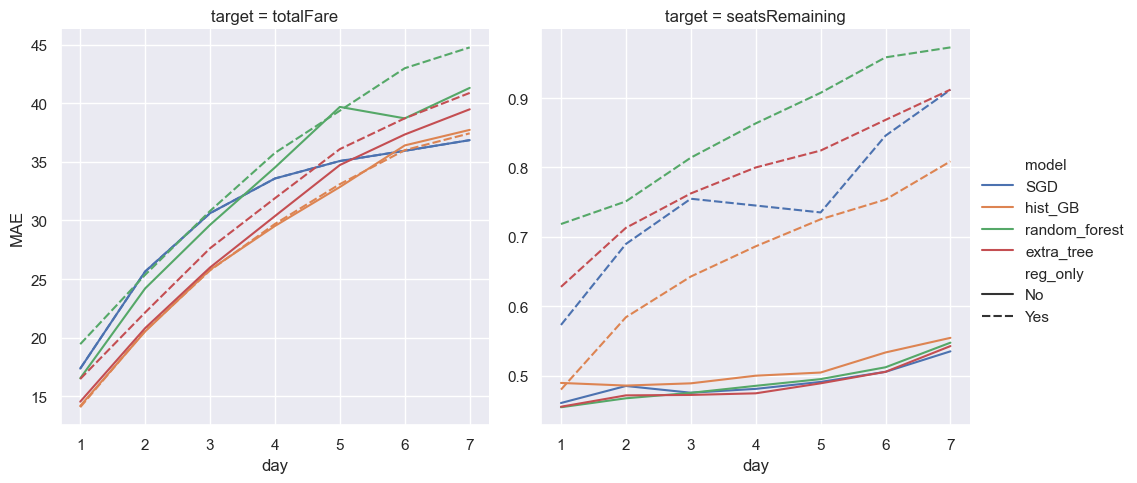

MAE                      
                                            mean        max        min
target         model         reg_only                                 
seatsRemaining SGD           No         0.490611   0.535130   0.460707
                             Yes        0.750841   0.911930   0.573122
               extra_tree    No         0.487340   0.542705   0.455329
                             Yes        0.786925   0.912103   0.628000
               hist_GB       No         0.508166   0.554560   0.485804
                             Yes        0.668776   0.808824   0.480021
               random_forest No         0.491107   0.547620   0.454577
                             Yes        0.855177   0.972937   0.718499
totalFare      SGD           No        30.728393  36.867228  17.341857
                             Yes       30.728393  36.867228  17.341857
               extra_tree    No        29.038781  39.501632  14.515549
                             Yes       30.551393  40.902047  16.455198
               hist_GB       No        28.145118  37.742903  14.152516
                             Yes       28.089400  37.446862  14.039554
               random_forest No        32.090623  41.332119  16.514614
                             Yes       34.081187  44.791803  19.431441

In [151]:
from IPython.display import display
from sklearn.metrics import mean_absolute_error

def load_y_pred(path: str) -> dict[str, np.ndarray]:
    with np.load(path) as f:
        y_preds = dict(f)
    return y_preds

def _melt_relplot(fare_mae: pd.DataFrame, seat_mae: pd.DataFrame):
    fare_mae["day"] = np.arange(N_STEPS) + 1
    fare_mae["target"] = "totalFare"
    seat_mae["day"] = np.arange(N_STEPS) + 1
    seat_mae["target"] = "seatsRemaining"
    mae = pd.concat([fare_mae, seat_mae])
    melt = pd.melt(mae, ["day", "target"], var_name="model", value_name="MAE")

    by = ["target", "model"]
    style = style_order = None
    if melt["model"].str.contains("_reg_only").any():
        style = "reg_only"
        by.append(style)
        style_order = ["No", "Yes"]
        melt["reg_only"] = np.where(
            melt["model"].str.contains("_reg_only"), "Yes", "No"
        )
        melt["model"] = melt["model"].str.replace("_reg_only", "")

    sns.relplot(
        melt, x="day", y="MAE", hue="model", style=style, kind="line",
        style_order=style_order, col="target", facet_kws={"sharey": False}
    )
    plt.show()
    display(melt.drop(columns="day").groupby(by).agg(["mean", "max", "min"]))

def plot_mae(name_and_path: dict):
    y_true = load_y_pred("models/y_true.npz")
    fare_mae = {}
    seat_mae = {}
    for name, path in name_and_path.items():
        y_pred = load_y_pred(path)
        y_pred["seat"] = y_pred["seat"].round() # TODO: make sure rounded while saving
        for mae, target in zip((fare_mae, seat_mae), ("fare", "seat")):
            mae[name] = mean_absolute_error(
                y_true[target], y_pred[target], multioutput="raw_values"
            )
    _melt_relplot(pd.DataFrame(fare_mae), pd.DataFrame(seat_mae))


plot_mae(
    {
        "SGD": "models/SGD_l1_MO.npz",
        "SGD_reg_only": "models/SGD_l1_MO_reg_only.npz",
        "hist_GB": "models/hist_GB.npz",
        "hist_GB_reg_only": "models/hist_GB_reg_only.npz",
        "random_forest": "models/random_forest.npz",
        "random_forest_reg_only": "models/random_forest_reg_only.npz",
        "extra_tree": "models/extra_tree.npz",
        "extra_tree_reg_only": "models/extra_tree_reg_only.npz",
    }
)

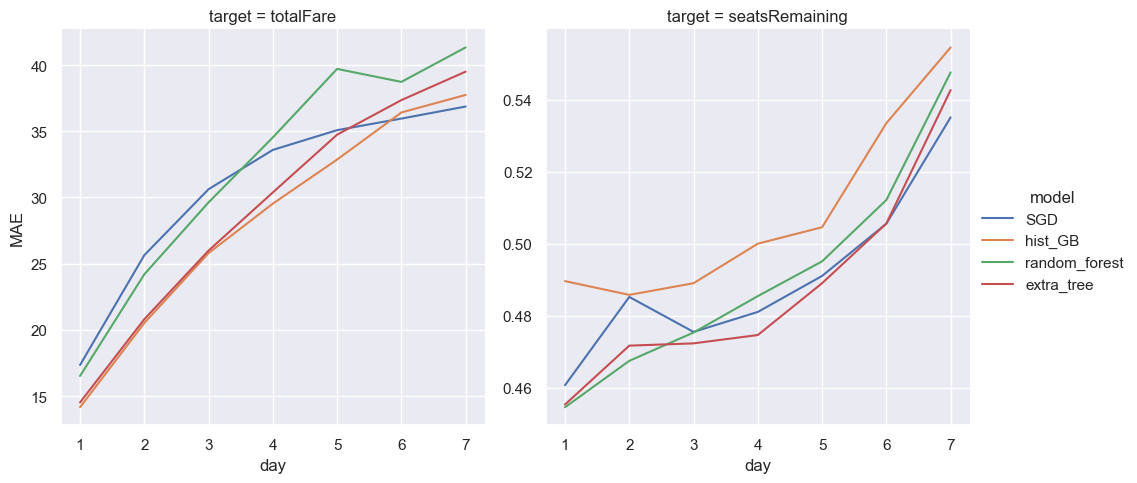

MAE                      
                                   mean        max        min
target         model                                         
seatsRemaining SGD             0.490611   0.535130   0.460707
               extra_tree      0.487340   0.542705   0.455329
               hist_GB         0.508166   0.554560   0.485804
               random_forest   0.491107   0.547620   0.454577
totalFare      SGD            30.728393  36.867228  17.341857
               extra_tree     29.038781  39.501632  14.515549
               hist_GB        28.145118  37.742903  14.152516
               random_forest  32.090623  41.332119  16.514614

In [152]:
plot_mae(
    {
        "SGD": "models/SGD_l1_MO.npz",
        "hist_GB": "models/hist_GB.npz",
        "random_forest": "models/random_forest.npz",
        "extra_tree": "models/extra_tree.npz",
    }
)

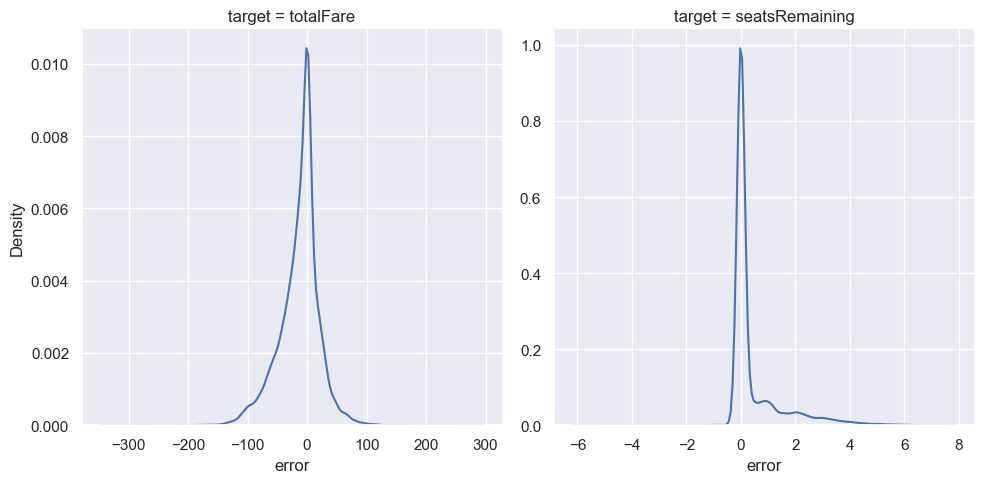

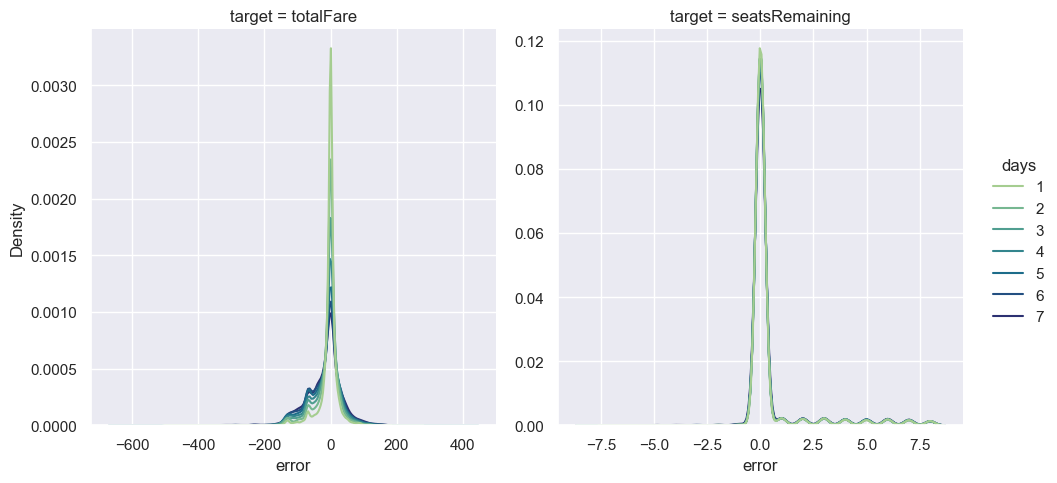

In [86]:
def error_dist(pred_path: str, days_avg: bool = True):
    y_true = load_y_pred("models/y_true.npz")
    y_pred = load_y_pred(pred_path)
    target_spec = {"fare": "totalFare", "seat": "seatsRemaining"}
    hue = None # set hue and palette only when ploting multiple lines (days_avg=False)
    palette = None
    if days_avg:
        errors = {
            # "totalFare": (y_pred["fare"] - y_true["fare"]).mean(axis=-1),
            # "seatsRemaining": (y_pred["seat"] - y_true["seat"]).mean(axis=-1),
            name: (y_pred[key] - y_true[key]).mean(axis=-1)
            for key, name in target_spec.items()
        }
        errors = pd.DataFrame(errors).melt(value_name="error", var_name="target")
    else:
        hue = "days"
        palette = "crest"
        errors = pd.concat(
            pd.DataFrame(y_pred[key] - y_true[key], columns=np.arange(7) + 1)
            .melt(value_name="error", var_name=hue).assign(target=name)
            for key, name in {"fare": "totalFare", "seat": "seatsRemaining"}.items()
        )
    sns.displot(
        errors, x="error", col="target", kind="kde", hue=hue, palette=palette,
        facet_kws={"sharex": False, "sharey": False}
    )
error_dist("models/extra_tree.npz")
error_dist("models/extra_tree.npz", days_avg=False)

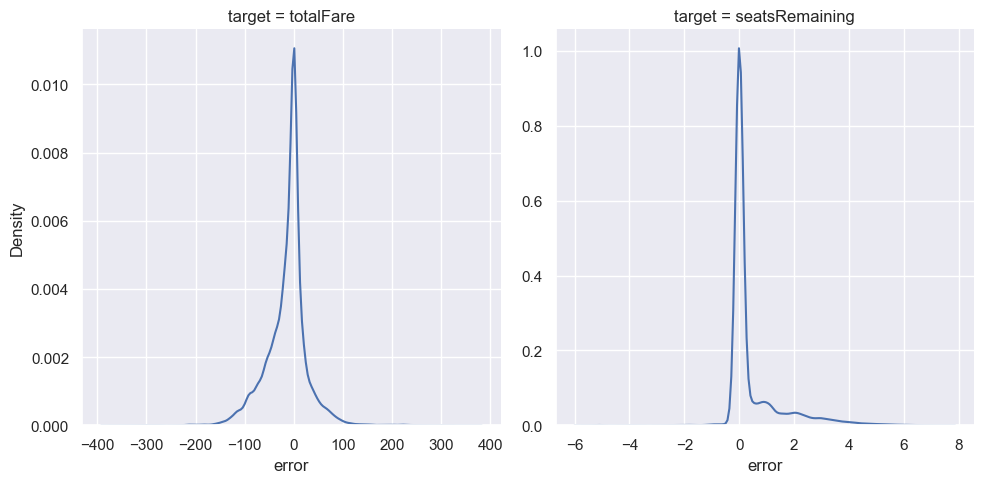

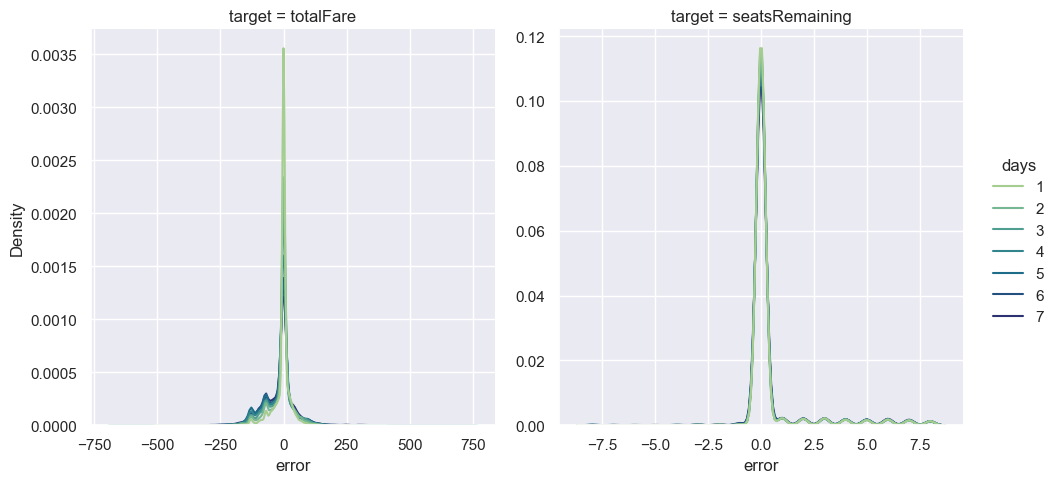

In [89]:
error_dist("models/random_forest.npz")
error_dist("models/random_forest.npz", days_avg=False)

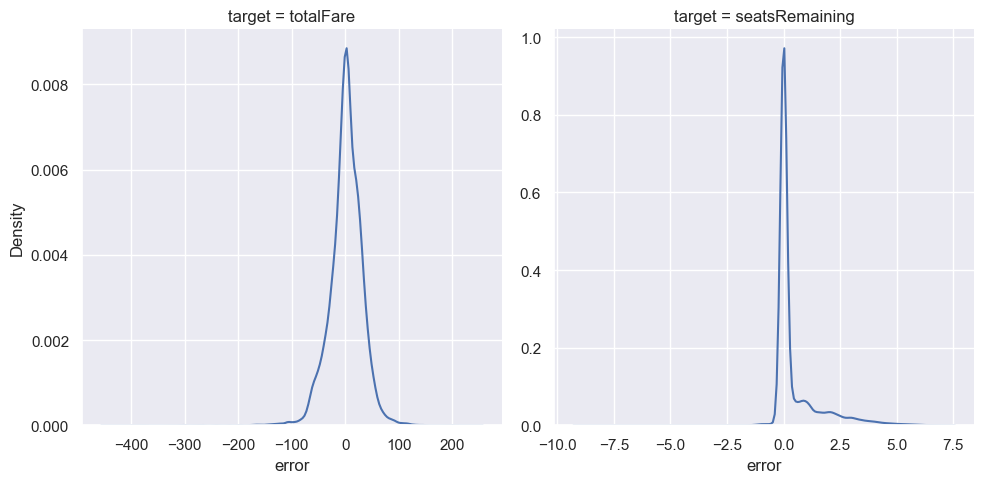

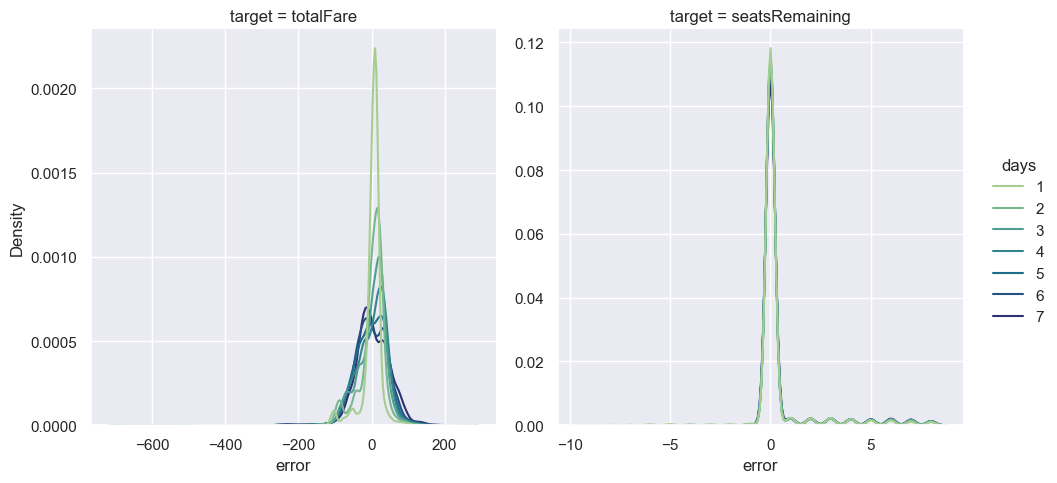

In [90]:
error_dist("models/SGD_l1_MO.npz")
error_dist("models/SGD_l1_MO.npz", days_avg=False)

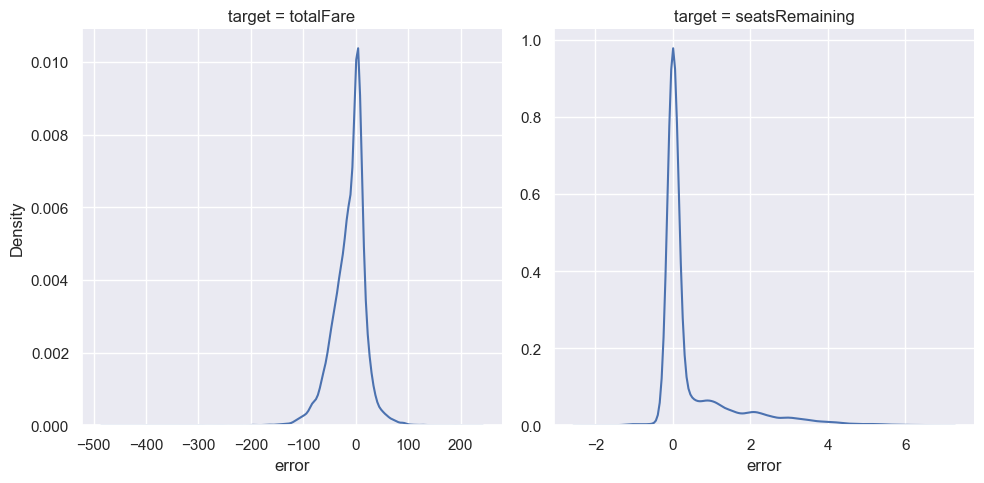

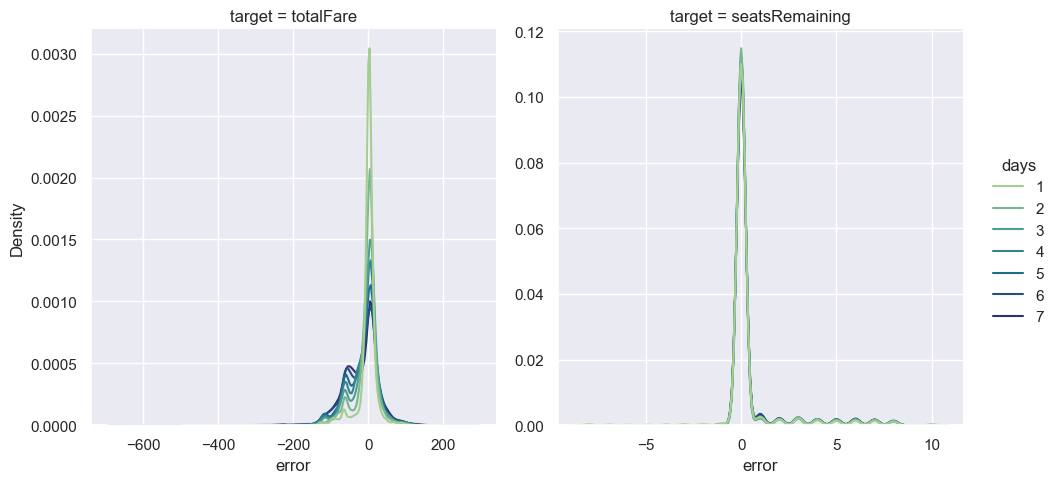

In [87]:
error_dist("models/hist_GB.npz")
error_dist("models/hist_GB.npz", days_avg=False)

### probe model

In [74]:
y_true = load_y_pred("models/y_true.npz")
best_history = {"fare": np.zeros(7), "seat": np.zeros(7), "fare_mean": np.inf, "seat_mean": np.inf}

def probe_model(window: WindowData, reg=None, clf=None):
    splits = SplitData(window)
    for i, fold in enumerate(splits.train_valid_split(1)):
        y_pred = _predict_reg_clf(fold, reg, clf) # tuple[np.ndarray]
        fare_pred = splits.denormalize_fare(y_pred[0], i)
        seat_pred = y_pred[1]
    length = fare_pred.shape[0]
    fare_mae = mean_absolute_error(y_true["fare"][-length:], fare_pred, multioutput="raw_values")
    seat_mae = mean_absolute_error(y_true["seat"][-length:], seat_pred, multioutput="raw_values")
    sns.pointplot(best_history["fare"]), sns.pointplot(fare_mae)
    plt.show()
    sns.pointplot(best_history["seat"]), sns.pointplot(seat_mae)
    plt.show()
    if fare_mae.mean() < best_history["fare_mean"] and seat_mae.mean() < best_history["seat_mean"]:
        print("New Record!")
        best_history["fare"], best_history["seat"] = fare_mae, seat_mae
        best_history["fare_mean"], best_history["seat_mean"] = fare_mae.mean(), seat_mae.mean()


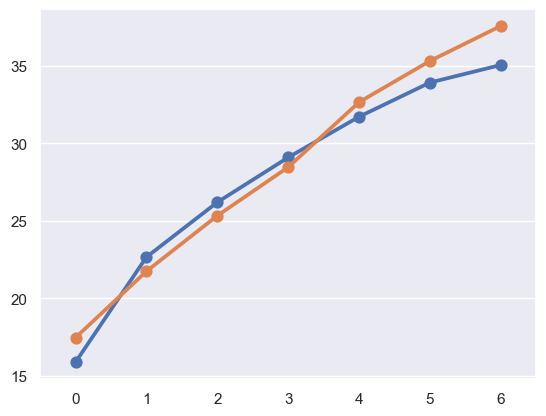

{'fare': array([15.88436075, 22.66281794, 26.20271839, 29.09717014, 31.72488346,
        33.93357358, 35.06768694]),
 'seat': array([0.58012048, 0.65783133, 0.58825301, 0.59698795, 0.64156627,
        0.67831325, 0.66686747]),
 'fare_mean': 27.796173027652667,
 'seat_mean': 0.6299913941480206}

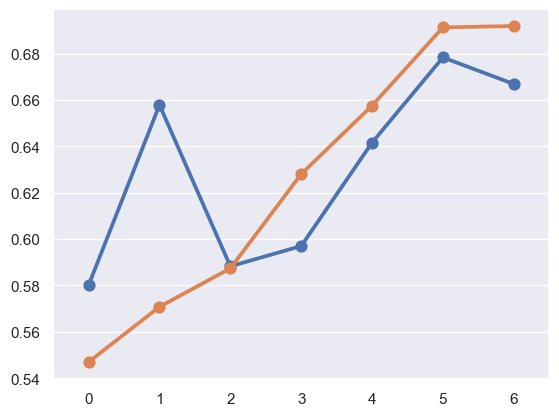

In [136]:
probe_model(
    window,
    reg=MultiOutputRegressor(
        HistGradientBoostingRegressor(
            # categorical_features=cat_feat_mask,
            l2_regularization=0.2,
            max_iter=1100,
            early_stopping=False,
        ),
        n_jobs=7,
    ),
    clf=MultiOutputClassifier(
        HistGradientBoostingClassifier(
            # categorical_features=cat_feat_mask,
            l2_regularization=0.2,
            max_iter=1100,
            early_stopping=False,
        ),
        n_jobs=7,
    ),
)
best_history

### save test run data

In [8]:
splits = SplitData(window)
fold_1 = next(splits.train_valid_split())

In [9]:
test_run_data = {
    "x": (fold_1["x"][0][-1200:], fold_1["x"][1][-1200:]),
    "y": (fold_1["y"][0][-1200:], fold_1["y"][1][-1200:]),
    "validation_data": (
        (fold_1["validation_data"][0][0][:120], fold_1["validation_data"][0][1][:120]),
        (fold_1["validation_data"][1][0][:120], fold_1["validation_data"][1][1][:120]),
    ),
    "sample_weight": fold_1["sample_weight"][-1200:],
}
joblib.dump(test_run_data, "test_run_data.gz")

['test_run_data.gz']

### CHECKPOINT

In [1]:
%run snapshot
import joblib

window = joblib.load("WindowData_window.gz")
# test_run_data = joblib.load("test_run_data.gz")

In [8]:
splits = SplitData(window)
fold_1 = next(splits.train_valid_split())
28 / splits._normalization_params[0]["y"][1]

0.21963074559748813

# Model

In [156]:
num_classes = np.unique(test_run_data["x"][1].reshape(-1, 2), axis=0).shape[0]

embed_n_feat = 2
embed_dim = 2

In [232]:
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Reshape
from keras.models import Model


encoded = Input(shape=(LAGS, 30), name="encoded")
embed = Input(shape=(LAGS, embed_n_feat), name="embed")

# Embedding layer for the second input
embedded_tensor2 = Embedding(input_dim=num_classes, output_dim=embed_dim)(embed)
embedded_tensor2 = Reshape((14, embed_n_feat * embed_dim))(embedded_tensor2)

# Concatenate the embedded tensor with the first input tensor
concatenated_tensor = Concatenate(axis=-1)([encoded, embedded_tensor2])

# Shared LSTM layer for both regression and classification
_lstm_output = LSTM(16, kernel_regularizer="l2", dropout=0.1, return_sequences=True)(concatenated_tensor)
_lstm_output = LSTM(16, kernel_regularizer="l2", dropout=0.1, return_sequences=True)(_lstm_output)
_lstm_output = LSTM(16 * N_STEPS, kernel_regularizer="l2", dropout=0.1)(_lstm_output)
lstm_output = Reshape((N_STEPS, 16))(_lstm_output)

# Regression output
reg_output = Dense(1, activation='linear', name='reg_output')(lstm_output)

# Classification output
clf_output = Dense(11, activation='softmax', name="clf_output")(lstm_output)

# _clf_output = Dense(11, activation="softmax")(lstm_output)
# clf_output = Permute((2, 1), name="clf_output")(_clf_output)

# clf_output = Dense(1, activation="relu", name="clf_output")(lstm_output)

# Define the model with two outputs
model = Model(inputs=[encoded, embed], outputs=[reg_output, clf_output])

# Compile the model with appropriate loss functions and metrics
model.compile(
    optimizer='adam', 
    loss={'reg_output': 'mse', 'clf_output': 'sparse_categorical_crossentropy'},
    # loss={'reg_output': 'mse', 'clf_output': 'mse'},
    metrics={'reg_output': 'mae', 'clf_output': 'accuracy'}
)

# Print model summary
model.summary()


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embed (InputLayer)             [(None, 14, 2)]      0           []                               
                                                                                                  
 embedding_23 (Embedding)       (None, 14, 2, 2)     118         ['embed[0][0]']                  
                                                                                                  
 encoded (InputLayer)           [(None, 14, 30)]     0           []                               
                                                                                                  
 reshape_34 (Reshape)           (None, 14, 4)        0           ['embedding_23[0][0]']           
                                                                                           

In [249]:
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Reshape, RepeatVector, LayerNormalization, TimeDistributed, add
from keras.models import Model


encoded = Input(shape=(LAGS, 30), name="encoded")
embed = Input(shape=(LAGS, embed_n_feat), name="embed")

embedded_tensor2 = Embedding(input_dim=num_classes, output_dim=embed_dim)(embed)
embedded_tensor2 = Reshape((14, embed_n_feat * embed_dim))(embedded_tensor2)

concatenated_tensor = Concatenate(axis=-1)([encoded, embedded_tensor2])

_lstm_output = LayerNormalization()(
    LSTM(16, kernel_regularizer="l1", dropout=0.1, return_sequences=True)(concatenated_tensor)
)
_lstm_output = LayerNormalization()(
    add([LSTM(16, kernel_regularizer="l1", dropout=0.1, return_sequences=True)(_lstm_output), _lstm_output])
)
_lstm_output = LayerNormalization()(
    add([LSTM(16, kernel_regularizer="l1", dropout=0.1, return_sequences=True)(_lstm_output), _lstm_output])
)
_lstm_output = LayerNormalization()(
    LSTM(16, kernel_regularizer="l1", dropout=0.1)(_lstm_output)
)
lstm_encode = RepeatVector(N_STEPS)(_lstm_output)
_lstm_decode = LayerNormalization()(
    add([LSTM(16, kernel_regularizer="l1", dropout=0.1, return_sequences=True)(lstm_encode), lstm_encode])
)
_lstm_decode = LayerNormalization()(
    add([LSTM(16, kernel_regularizer="l1", dropout=0.1, return_sequences=True)(_lstm_decode), _lstm_decode])
)
lstm_output = LayerNormalization()(
    add([LSTM(16, kernel_regularizer="l1", dropout=0.1, return_sequences=True)(_lstm_decode), _lstm_decode])
)

# Regression output
reg_output = TimeDistributed(
    Dense(1, activation='linear'), name='reg_output'
)(lstm_output)

# Classification output
clf_output = TimeDistributed(
    Dense(11, activation='softmax'), name="clf_output"
)(lstm_output)

model = Model(inputs=[encoded, embed], outputs=[reg_output, clf_output])

model.compile(
    optimizer='adam', 
    loss={'reg_output': 'mse', 'clf_output': 'sparse_categorical_crossentropy'},
    metrics={'reg_output': 'mae', 'clf_output': 'accuracy'}
)

model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embed (InputLayer)             [(None, 14, 2)]      0           []                               
                                                                                                  
 embedding_29 (Embedding)       (None, 14, 2, 2)     118         ['embed[0][0]']                  
                                                                                                  
 encoded (InputLayer)           [(None, 14, 30)]     0           []                               
                                                                                                  
 reshape_40 (Reshape)           (None, 14, 4)        0           ['embedding_29[0][0]']           
                                                                                           

In [251]:
from datetime import datetime

from keras.callbacks import CSVLogger, EarlyStopping

TIMESTAMP = datetime.now().strftime("log/%m%d_%H%M%S")
csv_logger = CSVLogger(f"{TIMESTAMP}.csv")
early_stopping = EarlyStopping(patience=500, monitor="val_reg_output_loss", mode="min", restore_best_weights=True)

history = model.fit(
    **test_run_data,
    epochs=20000,
    batch_size=32,
    callbacks=[early_stopping, csv_logger],
    shuffle=False
)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Val'], loc='upper left')
# plt.savefig(f"log_{TIMESTAMP}.png", dpi=300)

Epoch 1/20000
38/38 [==============================] - 19s 142ms/step - loss: 12.6628 - reg_output_loss: 0.5501 - clf_output_loss: 1.5929 - reg_output_mae: 0.6295 - clf_output_accuracy: 0.3694 - val_loss: 11.4136 - val_reg_output_loss: 0.5414 - val_clf_output_loss: 1.1254 - val_reg_output_mae: 0.6005 - val_clf_output_accuracy: 0.8060
Epoch 2/20000
38/38 [==============================] - 2s 50ms/step - loss: 9.9698 - reg_output_loss: 0.2724 - clf_output_loss: 0.7013 - reg_output_mae: 0.4575 - clf_output_accuracy: 0.8637 - val_loss: 9.3071 - val_reg_output_loss: 0.3195 - val_clf_output_loss: 0.8023 - val_reg_output_mae: 0.4545 - val_clf_output_accuracy: 0.8560
Epoch 3/20000
38/38 [==============================] - 2s 55ms/step - loss: 8.1792 - reg_output_loss: 0.1912 - clf_output_loss: 0.5257 - reg_output_mae: 0.3814 - clf_output_accuracy: 0.8911 - val_loss: 7.6528 - val_reg_output_loss: 0.2412 - val_clf_output_loss: 0.7066 - val_reg_output_mae: 0.3963 - val_clf_output_accuracy: 0.8738


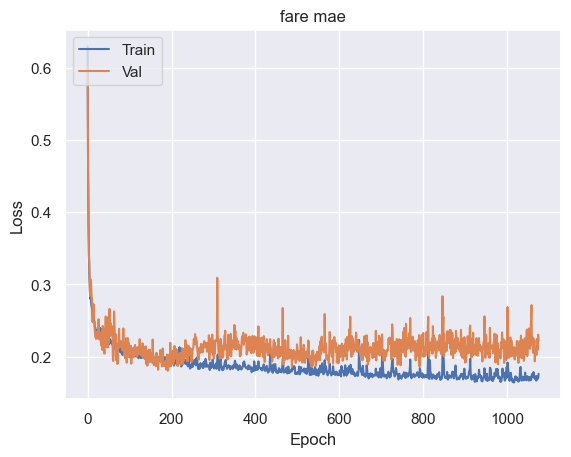

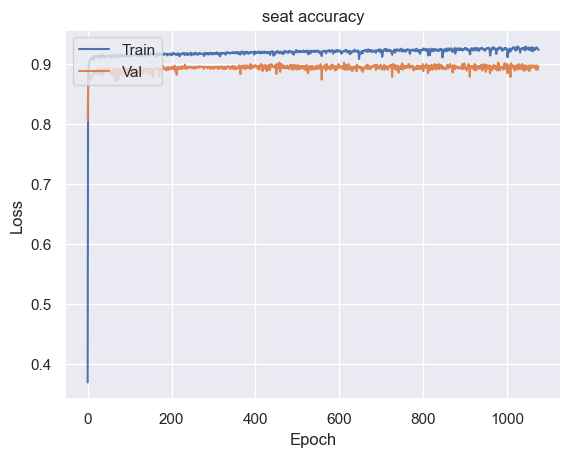

In [252]:
plt.plot(history.history["reg_output_mae"])
plt.plot(history.history["val_reg_output_mae"])
plt.title('fare mae')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.plot(history.history["clf_output_accuracy"])
plt.plot(history.history["val_clf_output_accuracy"])
plt.title('seat accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [33]:
import numpy as np

LAGS = 14
N_STEPS = 7
NUM_FEATURE = 8

window = np.random.randn(30, LAGS, N_STEPS, NUM_FEATURE)
# data

# np.save("random.npy", data)

In [34]:
import tensorflow as tf

input_ = tf.keras.layers.Input((None, N_STEPS, 2), batch_size=32)
# layer_1 = layers.TimeDistributed(layers.Conv1D(2, 3,))
layer_1 = tf.keras.layers.Conv1D(16, 3, padding="causal", activation="relu")


In [35]:
model = tf.keras.Sequential()
model.add(input_)
model.add(layer_1)

KeyboardInterrupt: 

In [ ]:
out = model(window)
out

<tf.Tensor: shape=(30, 14, 7, 16), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 3.91924739e-01, ...,
          0.00000000e+00, 3.36742431e-01, 4.18075353e-01],
         [0.00000000e+00, 0.00000000e+00, 5.61849475e-01, ...,
          1.54256597e-01, 6.22221768e-01, 0.00000000e+00],
         [0.00000000e+00, 8.92390907e-02, 1.22405544e-01, ...,
          4.29614991e-01, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 1.54263645e-01, 1.17220409e-01, ...,
          1.47766054e-01, 1.16234943e-01, 0.00000000e+00],
         [6.92876801e-03, 4.39506024e-01, 0.00000000e+00, ...,
          3.92811656e-01, 0.00000000e+00, 0.00000000e+00],
         [6.89206123e-01, 6.71508253e-01, 0.00000000e+00, ...,
          4.12966728e-01, 0.00000000e+00, 0.00000000e+00]],

        [[8.58484358e-02, 1.26741797e-01, 0.00000000e+00, ...,
          4.56594722e-03, 1.53104663e-01, 3.59340720e-02],
         [0.00000000e+00, 0.00000000e+00, 1.69496983e-01, ...,
          

# Autoencoder

In [ ]:
import numpy as np
import tensorflow as tf

LAGS = 14
N_STEPS = 7
NUM_FEATURE = 8

window = np.random.randn(30, LAGS, N_STEPS, NUM_FEATURE)

ae_encoder = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(LAGS, N_STEPS, NUM_FEATURE)),
        tf.keras.layers.Conv1D(16, 3, padding="same", activation="relu"),
        tf.keras.layers.Conv1D(16, 3, padding="same", activation="relu"),

    ]
)
ae_decoder = tf.keras.Sequential(
    [

        tf.keras.layers.Reshape([LAGS, N_STEPS, NUM_FEATURE])
    ]
)

!

In [ ]:
import pandas as pd

df = pd.read_parquet("full_df.parquet")

scaler = 1e9
window = df[["totalFare", "seatsRemaining", "segmentsDepartureTimeEpochSeconds", "searchDateInSeconds"]].values

trial_data = window[:139000].reshape(-1, 10, 4)

In [ ]:
standard_scaler = {
    "mean": trial_data.mean(axis=(0, 1)),
    "std": trial_data.std(axis=(0, 1)),
}
trial_data_norm = (trial_data - standard_scaler["mean"]) / standard_scaler["std"]

In [ ]:
import tensorflow as tf
from keras import layers

_model = tf.keras.Sequential(
    [
        layers.Input((10, 4)),
        layers.BatchNormalization(),

        # layers.Conv1D(16, 3, padding="same"),
        layers.Conv1D(8, 3, padding="same", activation="relu"),
        layers.Conv1D(4, 3, padding="same", activation="relu"),

        layers.Conv1D(2, 3, padding="same"),

        layers.Conv1DTranspose(4, 3, padding="same", activation="relu"),
        layers.Dropout(0.1),
        layers.Conv1DTranspose(8, 3, padding="same", activation="relu"),
        # layers.Conv1DTranspose(16, 3, padding="same"),

        layers.Dense(4)
    ]
)

_model.compile(optimizer="adam", loss="mae", metrics=["mse"])
_model.summary()
history = _model.fit(
    trial_data_norm,
    trial_data_norm,
    epochs=100,
    batch_size=32,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=10, monitor="loss", mode="min", restore_best_weights=True)
)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 10, 4)            16        
 hNormalization)                                                 
                                                                 
 conv1d_41 (Conv1D)          (None, 10, 8)             104       
                                                                 
 dropout_4 (Dropout)         (None, 10, 8)             0         
                                                                 
 conv1d_42 (Conv1D)          (None, 10, 4)             100       
                                                                 
 conv1d_43 (Conv1D)          (None, 10, 2)             26        
                                                                 
 conv1d_transpose_18 (Conv1D  (None, 10, 4)            28        
 Transpose)                                          

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from keras import layers

lstm_model = tf.keras.Sequential(
    [
        layers.Input((10, 2)),
        layers.LSTM(8, return_sequences=True),
        layers.LSTM(4),
        layers.RepeatVector(10),
        layers.LSTM(4, return_sequences=True),
        layers.LSTM(8, return_sequences=True),
        layers.TimeDistributed(layers.Dense(2))
    ]
)

_model.compile(optimizer="adam", loss="mse")

history = _model.fit(trial_data_norm, trial_data_norm, epochs=50, batch_size=32)

Epoch 1/50
435/435 [==============================] - 5s 9ms/step - loss: 3.2105e-05
Epoch 2/50
435/435 [==============================] - 4s 8ms/step - loss: 5.5274e-06
Epoch 3/50
435/435 [==============================] - 4s 8ms/step - loss: 9.1875e-06
Epoch 4/50
435/435 [==============================] - 4s 8ms/step - loss: 1.3325e-05
Epoch 5/50
435/435 [==============================] - 4s 9ms/step - loss: 1.1291e-05
Epoch 6/50
435/435 [==============================] - 4s 8ms/step - loss: 1.6810e-05
Epoch 7/50
435/435 [==============================] - 4s 8ms/step - loss: 7.4734e-06
Epoch 8/50
435/435 [==============================] - 4s 8ms/step - loss: 1.1237e-05
Epoch 9/50
435/435 [==============================] - 4s 9ms/step - loss: 7.0126e-06
Epoch 10/50
435/435 [==============================] - 4s 9ms/step - loss: 1.4123e-05
Epoch 11/50
435/435 [==============================] - 4s 8ms/step - loss: 9.6779e-06
Epoch 12/50
435/435 [==============================] - 4s 9ms/s

# Stash

Examine the weights of neurons

In [ ]:
import numpy as np

X = np.hstack([np.arange(100)[:, None], np.random.randn(100)[:, None]], dtype=np.float32)
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X = (X - X_mean) / X_std
y = X[:, 0]
# y = np.arange(100)[:, None]

In [ ]:
from keras import Sequential, layers, Model
from keras.callbacks import EarlyStopping

x_0 = layers.Input(1, name="input_0")
x_0_dense = layers.Dense(1, name="dense_0")(x_0)
x_1 = layers.Input(1, name="input_1")
x_1_dense = layers.Dense(1, name="dense_1")(x_1)
_X = layers.Concatenate()([x_0_dense, x_1_dense])
_X = layers.Dense(1, name="final_dense")(_X)

_model = Model(inputs=[x_0, x_1], outputs=_X)
_model.compile(optimizer="adam", loss="mse")

history = _model.fit([X[:, 0:1], X[:, 1:2]], y, epochs=5000, batch_size=32, callbacks=EarlyStopping(patience=100, monitor="loss", mode="min", restore_best_weights=True))
# history = _model.fit(X, y, epochs=5000, batch_size=32, callbacks=EarlyStopping(patience=100, monitor="loss", mode="min", restore_best_weights=True))

Epoch 1/5000
4/4 [==============================] - 0s 11ms/step - loss: 4.7247
Epoch 2/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.6711
Epoch 3/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.6224
Epoch 4/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.5730
Epoch 5/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.5238
Epoch 6/5000
4/4 [==============================] - 0s 8ms/step - loss: 4.4770
Epoch 7/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.4252
Epoch 8/5000
4/4 [==============================] - 0s 8ms/step - loss: 4.3795
Epoch 9/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.3327
Epoch 10/5000
4/4 [==============================] - 0s 8ms/step - loss: 4.2836
Epoch 11/5000
4/4 [==============================] - 0s 9ms/step - loss: 4.2374
Epoch 12/5000
4/4 [==============================] - 0s 10ms/step - loss: 4.1930
Epoch 13/5000
4/4 [============================

subplots

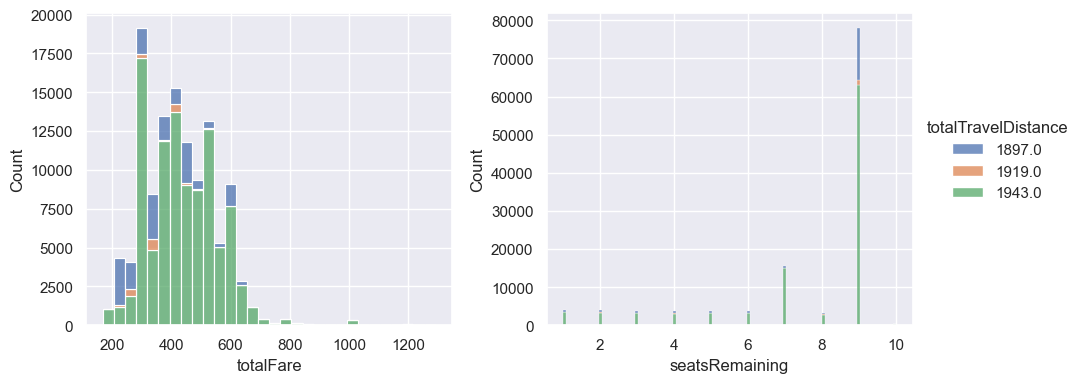

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.histplot(train, x="totalFare", hue="totalTravelDistance", palette="deep", multiple="stack", bins=30, ax=axes[0], legend=False)
sns.histplot(train, x="seatsRemaining", hue="totalTravelDistance", palette="deep", multiple="stack", ax=axes[1])
sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 0.7), frameon=False)
plt.tight_layout()

Number of tickets in different days of prices

In [ ]:
index_level0 = df.index.get_level_values(0)
legId_days = index_level0.value_counts(sort=False)

Text(1, 830, 'Flight tickets of timesteps under {LAGS + N_STEPS} days: 405')

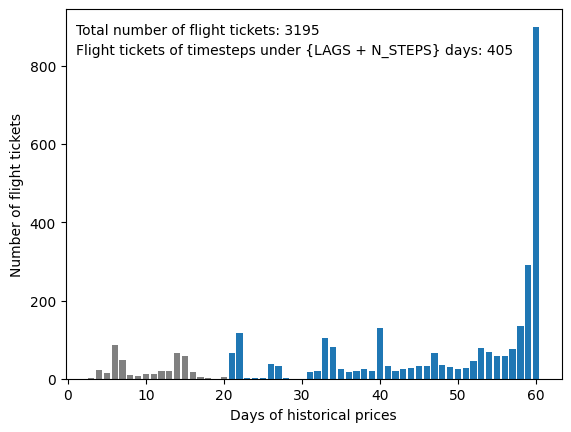

In [ ]:
import matplotlib.pyplot as plt

lengths_count = legId_days.value_counts().sort_index()

fig, ax = plt.subplots()

ax.bar(lengths_count.index, lengths_count)
ax.bar(
    lengths_count[lengths_count.index < LAGS + N_STEPS].index,
    lengths_count[lengths_count.index < LAGS + N_STEPS],
    color="gray"
)
ax.set_ylabel("Number of flight tickets")
ax.set_xlabel("Days of historical prices")
ax.text(1, 880, f"Total number of flight tickets: {lengths_count.sum()}")
ax.text(
    1,
    830,
    (
        f"Flight tickets of timesteps under {LAGS + N_STEPS} days: "
        f"{lengths_count[lengths_count.index < LAGS + N_STEPS].sum()}"
    )
)

Check the distribution of data

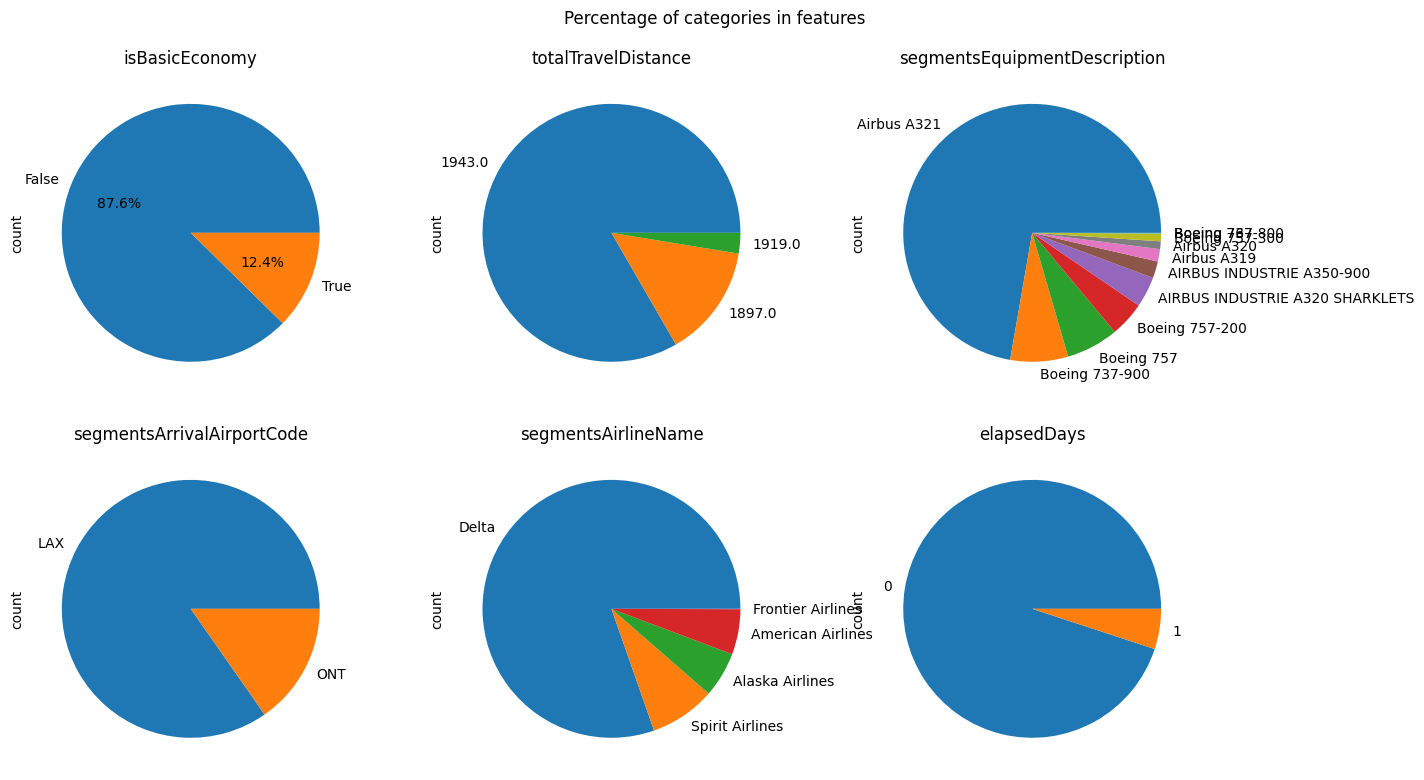

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
df["isBasicEconomy"].value_counts().plot.pie(ax=axes[0, 0], title="isBasicEconomy", autopct="%1.1f%%")
df["totalTravelDistance"].value_counts().plot.pie(ax=axes[0, 1], title="totalTravelDistance")
df["segmentsEquipmentDescription"].value_counts().plot.pie(ax=axes[0, 2], title="segmentsEquipmentDescription")
df["segmentsArrivalAirportCode"].value_counts().plot.pie(ax=axes[1, 0], title="segmentsArrivalAirportCode")
df["segmentsAirlineName"].value_counts().plot.pie(ax=axes[1, 1], title="segmentsAirlineName")
df["elapsedDays"].value_counts().plot.pie(ax=axes[1, 2], title="elapsedDays")

fig.suptitle("Percentage of categories in features")
fig.tight_layout()

Plot scatter_matrix

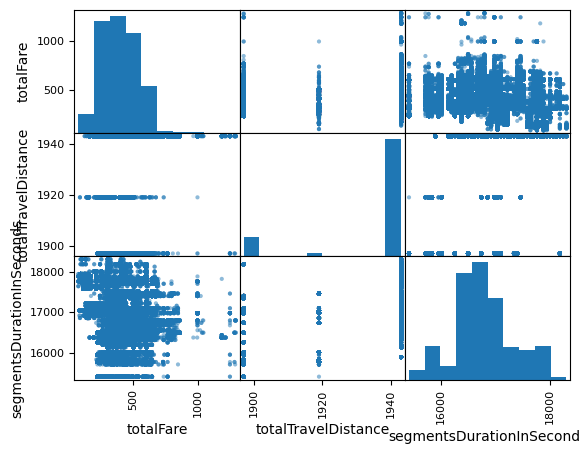

In [ ]:
from pandas.plotting import scatter_matrix

scatter_matrix(
    df[["totalTravelDistance", "segmentsArrivalAirportCode"]]
)
scatter_matrix(
    df[[
        "totalFare",
        "totalTravelDistance",
        "segmentsArrivalAirportCode",
        "segmentsDurationInSeconds",
    ]],
    # figsize=(12, 12),
);

Separate validation set

In [ ]:
valid_gen = (
    df[
        (df["searchDate"] > df["searchDate"].max() - pd.Timedelta(days=N_STEPS * fold_n - LAGS))
        & (df["searchDate"] <= df["searchDate"].max() - pd.Timedelta(days=N_STEPS * (fold_n - 1)))
    ]
    for fold_n in range(VALIDATION_FOLDS, 0, -1)
)
# valid_folds = (
#     df[df["searchDate"] > end_date - days["lags"]],


# )

impute the lost travel distance

In [ ]:
df.loc[df["segmentsArrivalAirportCode"] == "LAX", "totalTravelDistance"].fillna(1943, inplace=True)
df.loc[df["segmentsArrivalAirportCode"] == "ONT", "totalTravelDistance"].fillna(1919, inplace=True)

<Axes: title={'center': 'elapsedDays'}, ylabel='count'>

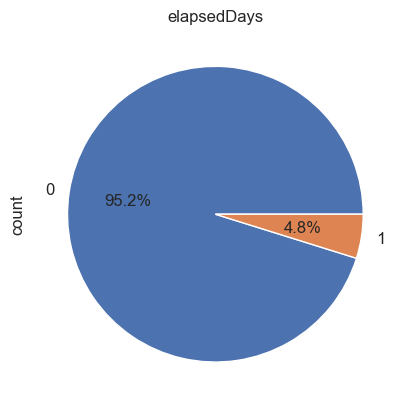

In [ ]:
train["elapsedDays"].value_counts().plot.pie(autopct="%1.1f%%", title="elapsedDays", fontsize=12)

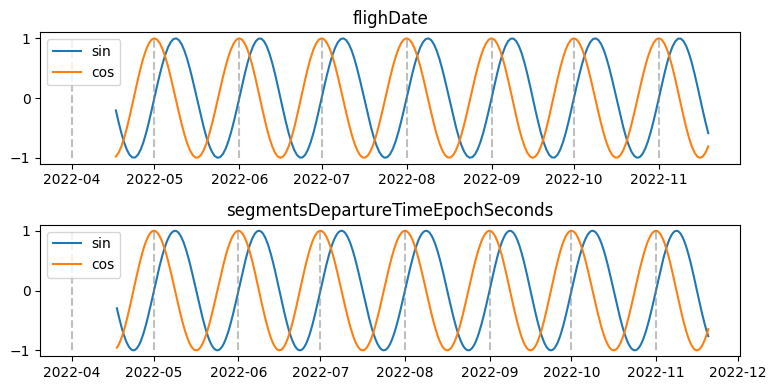

In [ ]:
def plot_month_encoded(timestamps: pd.Series, unit=None, ax=None):
    if unit:
        timestamps = pd.to_datetime(timestamps, unit=unit)

    sorted_idx = np.argsort(timestamps)
    sin, cos = cyclic_encode(timestamps, period="month", unit=unit)

    if not ax:
        fig, ax = plt.subplots()

    ax.plot(timestamps[sorted_idx], sin[sorted_idx], label="sin")
    ax.plot(timestamps[sorted_idx], cos[sorted_idx], label="cos")
    ax.vlines(
        [month_start(2021, i) for i in timestamps.dt.month.unique()],
        linestyle='--',
        ymin=-2,
        ymax=0,
        colors="gray",
        alpha=-1.5
    )
    ax.legend()


fig, axes = plt.subplots(2, 1, figsize=(8, 4))
plot_month_encoded(df["flightDate"], ax=axes[0])
axes[0].set_title("flighDate")
plot_month_encoded(df["segmentsDepartureTimeEpochSeconds"], ax=axes[1])
axes[1].set_title("segmentsDepartureTimeEpochSeconds")
fig.tight_layout()

In [ ]:
def ensure_2d_arr(func):
    def wrapper(array: np.ndarray, *args, **kwargs):
        if array.ndim == 1:
            array = array.reshape(-1, 1)
        return func(array, *args, **kwargs)
    return wrapper

@ensure_2d_arr
def foo(array: np.ndarray):
    return np.lib.stride_tricks.sliding_window_view(array, 14, axis=0).swapaxes(1, 2)

In [ ]:
from datetime import datetime

datetime.now().strftime("%m%d_%H%M%S")

'1111_180908'

In [ ]:
def window_input(data: np.ndarray):
    return np.lib.stride_tricks.sliding_window_view(data[:-N_STEPS], LAGS, axis=0).swapaxes(1, 2)

In [ ]:
import numpy as np

window = np.arange(1, 23)
window = np.array([window, window*10, window*100]).T
window

array([[   1,   10,  100],
       [   2,   20,  200],
       [   3,   30,  300],
       [   4,   40,  400],
       [   5,   50,  500],
       [   6,   60,  600],
       [   7,   70,  700],
       [   8,   80,  800],
       [   9,   90,  900],
       [  10,  100, 1000],
       [  11,  110, 1100],
       [  12,  120, 1200],
       [  13,  130, 1300],
       [  14,  140, 1400],
       [  15,  150, 1500],
       [  16,  160, 1600],
       [  17,  170, 1700],
       [  18,  180, 1800],
       [  19,  190, 1900],
       [  20,  200, 2000],
       [  21,  210, 2100],
       [  22,  220, 2200]])

In [ ]:
LAGS = 14
N_STEPS = 7

In [ ]:
# input data
np.lib.stride_tricks.sliding_window_view(window[:-N_STEPS], LAGS, axis=0).swapaxes(1, 2)

array([[[   1,   10,  100],
        [   2,   20,  200],
        [   3,   30,  300],
        [   4,   40,  400],
        [   5,   50,  500],
        [   6,   60,  600],
        [   7,   70,  700],
        [   8,   80,  800],
        [   9,   90,  900],
        [  10,  100, 1000],
        [  11,  110, 1100],
        [  12,  120, 1200],
        [  13,  130, 1300],
        [  14,  140, 1400]],

       [[   2,   20,  200],
        [   3,   30,  300],
        [   4,   40,  400],
        [   5,   50,  500],
        [   6,   60,  600],
        [   7,   70,  700],
        [   8,   80,  800],
        [   9,   90,  900],
        [  10,  100, 1000],
        [  11,  110, 1100],
        [  12,  120, 1200],
        [  13,  130, 1300],
        [  14,  140, 1400],
        [  15,  150, 1500]]])

In [ ]:
# normal out
np.lib.stride_tricks.sliding_window_view(window[LAGS:, :2], N_STEPS, axis=0).swapaxes(1, 2)

array([[[ 15, 150],
        [ 16, 160],
        [ 17, 170],
        [ 18, 180],
        [ 19, 190],
        [ 20, 200],
        [ 21, 210]],

       [[ 16, 160],
        [ 17, 170],
        [ 18, 180],
        [ 19, 190],
        [ 20, 200],
        [ 21, 210],
        [ 22, 220]]])

In [ ]:
# causal out
np.lib.stride_tricks.sliding_window_view(window[1:, :2], (N_STEPS, LAGS), (0, 0)).swapaxes(1, 3)

array([[[[  2,  20],
         [  3,  30],
         [  4,  40],
         [  5,  50],
         [  6,  60],
         [  7,  70],
         [  8,  80]],

        [[  3,  30],
         [  4,  40],
         [  5,  50],
         [  6,  60],
         [  7,  70],
         [  8,  80],
         [  9,  90]],

        [[  4,  40],
         [  5,  50],
         [  6,  60],
         [  7,  70],
         [  8,  80],
         [  9,  90],
         [ 10, 100]],

        [[  5,  50],
         [  6,  60],
         [  7,  70],
         [  8,  80],
         [  9,  90],
         [ 10, 100],
         [ 11, 110]],

        [[  6,  60],
         [  7,  70],
         [  8,  80],
         [  9,  90],
         [ 10, 100],
         [ 11, 110],
         [ 12, 120]],

        [[  7,  70],
         [  8,  80],
         [  9,  90],
         [ 10, 100],
         [ 11, 110],
         [ 12, 120],
         [ 13, 130]],

        [[  8,  80],
         [  9,  90],
         [ 10, 100],
         [ 11, 110],
         [ 12, 120],
 

In [ ]:
from dataclasses import field, dataclass

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder


class Pipeline:
    target_names = ("totalFare", "seatsRemaining")
    encoding_spec = {
        "Ordinal": ["segmentsAirlineName", "fareBasisCode"],
        "OneHot": ["segmentsArrivalAirportCode", "segmentsEquipmentDescription"],
    }
    lags = LAGS
    n_steps = N_STEPS
    validation_folds = VALIDATION_FOLDS

    encoders = {}

    def __init__(self, df: pd.DataFrame):
        if df is None:
            return
        self.data = self.clean_impute_df(df)
        self.metadata = {
            "legId": self.data.pop("legId"),
            "searchDate": self.data["searchDate"],
            "imputed" : self.data.pop("imputed"),
        }
        self.columns, self._x, self._y = self.encode()
        self._window, self._causal = self.sliding_window(self._x, self._y)

    @classmethod
    def read_csv(cls, filepath: str, **kwargs):
        return cls(pd.read_csv(filepath, **kwargs))

    @classmethod
    def reload(cls, old: "Pipeline"):
        new = cls(None)
        new.data = old.data
        new.metadata = old.metadata
        new.encoders = old.encoders
        new._x = old._x
        new._y = old._y
        new.columns = old.columns
        new._window = old._window
        new._causal = old._causal
        return new

    @staticmethod
    def clean_impute_df(df: pd.DataFrame) -> dict[str, np.ndarray]:
        selected_features = [
            "searchDate", "segmentsDepartureTimeEpochSeconds", "legId",
            "fareBasisCode", "segmentsArrivalAirportCode", "segmentsAirlineName",
            "segmentsEquipmentDescription", "totalFare", "seatsRemaining",
            "isBasicEconomy", "totalTravelDistance", "segmentsDurationInSeconds",
        ]
        return (
            df.loc[:, selected_features]
            .pipe(convert_timestamps)
            .pipe(filter_and_sort)
            .pipe(impute_null_data)
            .pipe(fill_distance)
            .pipe(fill_equipment)
            .pipe(impute_lost_days)
        )
    
    def fit_encoders(self):
        search_date = self.data["searchDate"]
        last_day = search_date.max() - pd.Timedelta(days=N_STEPS * VALIDATION_FOLDS)
        train_mask = search_date <= last_day

        for feature in self.encoding_spec["Ordinal"]:
            self.encoders[feature] = OrdinalEncoder(
                dtype=np.float32,
                handle_unknown="use_encoded_value",
                unknown_value=-1,
            )
            self.encoders[feature].fit(self.data[feature][train_mask].reshape(-1, 1))
        for feature in self.encoding_spec["OneHot"]:
            self.encoders[feature] = OneHotEncoder(
                dtype=np.float32,
                handle_unknown="infrequent_if_exist",
                min_frequency=0.01,
                sparse_output=False,
                feature_name_combiner=lambda _, category: f"{feature}_{category}",
            )
            self.encoders[feature].fit(self.data[feature][train_mask].reshape(-1, 1))

    def encode(self):
        if not self.encoders:
            self.fit_encoders()

        # Ordinal encode
        embed_data = {}
        for feature in self.encoding_spec["Ordinal"]:
            arr = self.data.pop(feature)
            enc = self.encoders[feature]
            embed_data[feature] = enc.transform(arr.reshape(-1, 1))
        # One Hot encode
        for feature in self.encoding_spec["OneHot"]:
            arr = self.data.pop(feature)
            enc = self.encoders[feature]
            arr = enc.transform(arr.reshape(-1, 1))
            self.data.update(
                {name: arr[:, i] for i, name in enumerate(enc.get_feature_names_out())}
            )
        # Cyclic encode
        period_args = {
            "searchDate": ["week", "month", "year"],
            "segmentsDepartureTimeEpochSeconds": ["day", "week", "month", "year"],
        }
        for feature, period_list in period_args.items():
            arr = self.data.pop(feature)
            for period in period_list:
                waves = cyclic_encode(arr, period=period)
                descr = f"{feature}_{period}"
                self.data.update({f"{descr}_sin": waves[0], f"{descr}_cos": waves[1]})

        # return (columns, x, y)
        return (
            tuple(tuple(data.keys()) for data in (self.data, embed_data)),
            tuple(
                np.column_stack(tuple(data.values())).astype(np.float32)
                for data in (self.data, embed_data)
            ),
            np.column_stack(tuple(self.data[name] for name in self.target_names)),
        )
    
    def sliding_window(self, x, y):
        window = self.WindowData(x=tuple([] for _ in x))
        causal = self.WindowData()

        search_date = self.metadata["searchDate"].reshape(-1, 1)
        imputed = self.metadata["imputed"].reshape(-1, 1)
        for leg_slice in self._leg_slice_generator():
            for frag_list, arr in zip(window.x, x):
                frag_list.append(self._window_x(arr[leg_slice]))
            window.y.append(self._window_y(y[leg_slice]))
            window.imputed_x.append(self._window_x(imputed[leg_slice]))
            window.imputed_y.append(self._window_y(imputed[leg_slice]))
            window.date.append(self._window_y(search_date[leg_slice]))
            causal.y.append(self._window_y(y[leg_slice], causal=True))
            causal.imputed_y.append(self._window_y(imputed[leg_slice], causal=True))

        window.vstack_samples()
        causal.vstack_samples()

        # convert imputed counts to imputed rate (percentage)
        window.imputed_x = self._compute_imputed_rate(window.imputed_x)
        window.imputed_y = self._compute_imputed_rate(window.imputed_y)
        # use last date of samples to split train, validation and test set
        window.date = window.date[:, -1].copy()
        # data for causal model only differ from output (y)
        causal.x = window.x
        causal.imputed_x = window.imputed_x
        causal.date = causal.date

        return window, causal

    @dataclass
    class WindowData:
        x: tuple[list | np.ndarray] = field(default_factory=list)
        y: list | np.ndarray = field(default_factory=list)
        imputed_x: list | np.ndarray = field(default_factory=list)
        imputed_y: list | np.ndarray = field(default_factory=list)
        date: list | np.ndarray = field(default_factory=list)
      
        def vstack_samples(self):
            for field_name in self.__dataclass_fields__:
                attr = getattr(self, field_name)
                if not attr:
                    continue
                if isinstance(attr, tuple):
                    attr = tuple(np.vstack(arr) for arr in attr)
                else:
                    attr = np.vstack(attr)
                setattr(self, field_name, attr)

    def _leg_slice_generator(self):
        leg_counts = pd.Series(self.metadata["legId"]).value_counts(sort=False)
        pos = 0
        for span in leg_counts:
            yield slice(pos, pos+span)
            pos += span

    def _window_x(self, array: np.ndarray):
        return np.lib.stride_tricks.sliding_window_view(
            array[:-self.n_steps],
            window_shape=self.lags,
            axis=0
        ).swapaxes(1, 2)

    def _window_y(self, array: np.ndarray, causal: bool = False):
        if causal:
            return np.lib.stride_tricks.sliding_window_view(
                array[1:],
                window_shape=(self.n_steps, self.lags),
                axis=(0, 0),
            ).swapaxes(1, 3)
        else:
            return np.lib.stride_tricks.sliding_window_view(
                array[self.lags:],
                window_shape=self.n_steps,
                axis=0,
            ).swapaxes(1, 2)

    @staticmethod
    def _compute_imputed_rate(imputed: np.ndarray):
        axis_to_sum = tuple(range(1, imputed.ndim))
        return imputed.sum(axis=axis_to_sum) / np.prod(imputed.shape[1:])

    # def sliding_window(self, causal=False):
    #     x_frag = self.WindowData([list() for _ in self.x])
    #     y_frag = self.WindowData()

    #     def append_windows(attr, arr, sl):
    #         getattr(x_frag, attr).append(self._window_x(arr[sl]))
    #         getattr(y_frag, attr).append(self._window_y(arr[sl], causal))

    #     search_date = self.metadata["searchDate"].reshape(-1, 1)
    #     imputed = self.metadata["imputed"].reshape(-1, 1)
    #     for leg_slice in self.leg_slice_generator():
    #         for frag_list, arr in zip(x_frag.values, self.x):
    #             frag_list.append(self._window_x(arr[leg_slice]))
    #         y_frag.values.append(self._window_y(arr[leg_slice], causal))
    #         append_windows("date", search_date, leg_slice)
    #         append_windows("imputed", imputed, leg_slice)

    #     x_frag.values = tuple(np.vstack(_values) for _values in x_frag.values)
    #     y_frag.values = np.vstack(y_frag.values)
    #     x_frag.date = np.vstack(x_frag.date)
    #     y_frag.date = np.vstack(y_frag.date)
    #     x_frag.imputed = np.vstack(x_frag.imputed)
    #     y_frag.imputed = np.vstack(y_frag.imputed)
        
    #     return {"x": x_frag, "y": y_frag}

    # def sliding_window_old(self):
    #     x_frag = tuple([] for _ in self.x)
    #     y_frag = []
    #     search_date = self.metadata["searchDate"].reshape(-1, 1)
    #     date_x_frag = []
    #     date_y_frag = []
    #     imputed = self.metadata["imputed"].reshape(-1, 1)
    #     imputed_x_frag = []
    #     imputed_y_frag = []
    #     for leg_slice in self.leg_slice_generator():
    #         for i, arr in enumerate(self.x):
    #             x_frag[i].append(self._window_x(arr[leg_slice]))
    #         y_frag.append(self._window_y(self.y[leg_slice]))
    #         date_x_frag.append(self._window_x(search_date[leg_slice]))
    #         date_y_frag.append(self._window_y(search_date[leg_slice]))
    #         imputed_x_frag.append(self._window_x(imputed[leg_slice]))
    #         imputed_y_frag.append(self._window_y(imputed[leg_slice]))
    #     return {
    #         "x": tuple(np.vstack(arr_list) for arr_list in x_frag),
    #         "y": np.vstack(y_frag),
    #         "date_x": np.vstack(date_x_frag),
    #         "date_y": np.vstack(date_y_frag),
    #         "imputed_x": np.vstack(imputed_x_frag),
    #         "imputed_y": np.vstack(imputed_y_frag),
    #     }


In [ ]:
p = Pipeline.read_csv("ATL_to_LAX_nonstop_coach.csv")
# p.encode()

In [ ]:
from copy import deepcopy

backup = deepcopy(p)

In [ ]:
p = Pipeline.reload(backup)

# Show allocated memory

In [42]:
from psutil import Process

print(f"{Process().memory_info().rss / 2 ** 20:.2f} MB")
# Process().memory_percent()

995.89 MB
